<center>

# SITE SUITABILITY ANALYSIS

© team_eleven

<center>

<center>

*Site suitability is the process of understanding existing site qualities and factors, which will determine the location of a particular activity.*

<center>

<a id="linkme"></a>

<center>

## TABLE OF CONTENTS

### <a href=#one>1 Packages</a>

### <a href=#two>2 Introduction</a>

<a href=#two_one>*2.1 GEOID*</a>

<a href=#two_two>*2.2 The American Community Survey (ACS)*</a>

<a href=#two_three>*2.3 Methodology*</a>

### <a href=#three>3 Stage One</a>

<a href=#three_one>*3.1 Small site of interest*</a>

<a href=#three_two>*3.2 Small activity of interest*</a>

### <a href=#four>4 OSMPythonTools</a>

### <a href=#five>5 QGIS | OpenStreetMap</a>

### <a href=#six>6 Cenpy</a>

### <a href=#seven>7 United States Census Bureau | Census Reporter</a>

<a href=#seven_one>*7.1 Region population*</a>

<a href=#seven_two>*7.2 Household, economic and social characteristics*</a>

<a href=#seven_three>*7.3 Merge census data*</a>

<a href=#seven_four>*7.4 Check data integrity*</a>

### <a href=#eight>8 Spatial Join</a>

<a href=#eight_one>*8.1 Merge region attributes*</a>

<a href=#eight_two>*8.2 Merge count of attribute*</a>

### <a href=#nine>9 Geovisualization</a>

### <a href=#ten>10 Geodemographic Segmentation</a>

### <a href=#eleven>11 Weights and Prediction</a>

### <a href=#twelve>12 Stage Two</a>

<a href=#twelve_one>*12.1 Large activity*</a>

<a href=#twelve_two>*12.2 Sectors of interest*</a>

<a href=#twelve_three>*12.3 Making suitability predictions*</a>

<center>

<a id="one"></a>

<center>

## PACKAGES
Importing and briefly discussing libraries used during analysis and modelling

<a href=#linkme>*back to table of contents*</a>

<center>

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
from functools import reduce
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import requests
import folium
from folium.features import DivIcon
from folium import plugins
import altair as alt
import cenpy as cen
import contextily as ctx
import mapclassify
import geopandas as gpd
import geoviews as gv
import geoviews.feature as gf
import xarray as xr
from cartopy import crs
from holoviews.plotting.util import process_cmap
import esda
import libpysal as lps
from libpysal.weights import Queen, Rook, KNN, Kernel, DistanceBand
from splot.libpysal import plot_spatial_weights
import hvplot.pandas
from splot.esda import plot_local_autocorrelation
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from branca.element import Figure, Template, MacroElement
import io
from PIL import Image
import os
import time
from selenium import webdriver

In [2]:
nominatim = Nominatim()
overpass = Overpass()

In [ ]:
# pip install 

<a id="two"></a>

<center>

## INTRODUCTION
Introducing the subject matter

<a href=#linkme>*back to table of contents*</a>

<center>

<a id="two_one"></a>
### GEOID

<a href=#two>*back to introduction*</a>

What is the Geographic Identifiers (GEOIDs), also called FIPS code?

- [Understanding Geographic Identifiers](https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html)

![fips code](https://customer.precisely.com/servlet/rtaImage?eid=ka06g000001hQNJ&feoid=00N6g00000TynF6&refid=0EM6g0000010wuS)

[*Precisely*](https://customer.precisely.com/s/article/US-Census-definitions-of-a-Geography-and-FIPS-CODES?language=en_US)

![fips code](https://learn.arcgis.com/en/related-concepts/GUID-D7AA4FD1-E7FE-49D7-9D11-07915C9ACC68-web.png)

[*ESRI*](https://learn.arcgis.com/en/related-concepts/united-states-census-geography.htm)

<a id="two_two"></a>
### The American Community Survey (ACS)
*Choice product for this project*

<a href=#two>*back to introduction*</a>

Justification

- **Specificity**: offers the best balance of timeliness and geographic specificity.
- **Continuous & Region Extensive**: data is released annually in two forms:
    - 1-year release; only available for geographies with a population of 65,000 or more
    - 5-year release; which is available for almost all Census geographies, block group and larger (selected release)
- **Data Extensive**: In addition to data on age, sex, race and housing, the ACS includes data about education, income, occupation, veteran status, ancestry, and other topics.

[*Census Reporter*](https://censusreporter.org/topics/about-census/)

<a id="two_three"></a>
### Methodology

<a href=#two>*back to introduction*</a>

- Stage one: Small Site / Small Activity
- Stage two: Small Site / Large Activity
- Stage three: Large Site / Large Activity

Small Site          -->     St. Louis <br />
Small Activity      -->     Student Accommodation <br />
Large Activity      -->     Sectors within site of interest <br />
Large Site          -->     United States of America 

<a id="three"></a>

<center>

## STAGE ONE
Small Site / Small Activity

<a href=#linkme>*back to table of contents*</a>

<center>

<a id="three_one"></a>
### Small site of interest
*Randomly selected to avoid selection bias*

<a href=#three>*back to stage one*</a>

**St. Louis**

St. Louis is a major city in Missouri, located the Mississippi River with 104 census tracts

*Fun Fact - Its iconic, 630-ft. Gateway Arch, built in the 1960s, honors the early 19th-century explorations of Lewis and Clark and America's westward expansion in general.*

In [6]:
# request St Louis data from OSM

base_url =  "https://nominatim.openstreetmap.org/search?format=json"
postcode = "63108"
response = requests.get(f"{base_url}&postalcode={postcode}&country=United States")
data = response.json()

In [7]:
# St Louis latitude and longitude

latitude = data[0].get("lat")
longitude = data[0].get("lon")

latitude, longitude

('38.64637080947489', '-90.25510507564688')

In [8]:
# map of St Louis using folium

fig_slmap = Figure(height=600,width=1000)

location = float(latitude), float(longitude)

stlouis_map = folium.Map(location=location, zoom_start=12)

folium.Marker(location, popup="St. Louis").add_to(stlouis_map)

fig_slmap.add_child(stlouis_map)

stlouis_map

In [9]:
# save folium map
# mozilla firefox required
#from selenium import webdriver

map_name = "output/stlouis.png"
map_data = stlouis_map._to_png(5)
map_image = Image.open(io.BytesIO(map_data))
map_image.save(map_name)

In [ ]:
# method 2 to save folium map

# map_name = "output/stlouis.html"
# stlouis_map.save(map_name)

# map_url = "file://{0}/{1}".format(os.getcwd(), map_name)

# driver = webdriver.Firefox()
# driver.get(map_url)
# time.sleep(5)
# driver.save_screenshot("output/stlouis2.png")
# driver.quit()

<a id="three_two"></a>
### Small activity of interest

<a href=#three>*back to stage one*</a>

**Student accommodation**

Market: Students enrolled in colleges and universities. <br />
*The St. Louis metro area is home to about a third of Missouri’s nearly 50 colleges and universities.* <br />
[*USNews*](https://www.usnews.com/best-colleges/rankings/st.-louis)

Competition: Students accommodation options (rental vacancy rate)

Other factors: Healthcare, Landuse, Distance away from vulnerability (Prison, Cemetary, Highways)

<a id="four"></a>

<center>

## OSMPythonTools
Importing data using OSMPythonTools

<a href=#linkme>*back to table of contents*</a>

<center>

In [10]:
# extract location information

city = nominatim.query("St Louis, United States")
city.areaId()   # location ID


3601180533

In [11]:
# prepare query

school_query = overpassQueryBuilder(
    area=city.areaId(),
    elementType='node',                     # which are points (OSM also has ways and relations)
    selector='"amenity"="school"',          # tag required
    out='body',                             # body indicates that we want the data, not just the count
    includeGeometry=True                    # and we want the geometric information, too
)

# execute query
school_data = overpass.query(school_query, timeout=60)

In [12]:
print("Number of nodes found: {}".format(school_data.countElements()))

# school_data.nodes()[6].tags()                        


Number of nodes found: 44


In [13]:
# tags for item nth in extracted information

nth = 3

school_data.nodes()[nth].tags()

{'amenity': 'school',
 'ele': '151',
 'gnis:county_id': '510',
 'gnis:created': '10/24/1980',
 'gnis:feature_id': '765710',
 'gnis:state_id': '29',
 'name': 'Longfellow School'}

In [14]:
school_loc = [(item.id(), item.geometry()) for item in school_data.nodes()]
for item in school_data.nodes():
    print(item.geometry() ,' ', item.id() )

{"coordinates": [-90.226501, 38.620885], "type": "Point"}   358083413
{"coordinates": [-90.242891, 38.577552], "type": "Point"}   358083417
{"coordinates": [-90.31267, 38.596246], "type": "Point"}   358083525
{"coordinates": [-90.304559, 38.607274], "type": "Point"}   358083529
{"coordinates": [-90.235668, 38.616996], "type": "Point"}   358083532
{"coordinates": [-90.276288, 38.663518], "type": "Point"}   358083640
{"coordinates": [-90.292892, 38.625607], "type": "Point"}   358083663
{"coordinates": [-90.244557, 38.69644], "type": "Point"}   358083682
{"coordinates": [-90.23539, 38.616996], "type": "Point"}   358083706
{"coordinates": [-90.276225, 38.562552], "type": "Point"}   358083725
{"coordinates": [-90.274002, 38.670885], "type": "Point"}   358083753
{"coordinates": [-90.285392, 38.661163], "type": "Point"}   358083762
{"coordinates": [-90.252891, 38.630329], "type": "Point"}   358083793
{"coordinates": [-90.227334, 38.652273], "type": "Point"}   358083798
{"coordinates": [-90.20

In [15]:
# get ids and coordinates of schools

school_loc = [(item.id(), item.geometry()) for item in school_data.nodes()]

# create GeoDataFrame

schools = gpd.GeoDataFrame(school_loc, columns=["id", "geometry"])

schools.head()

,id,geometry
0,358083413,POINT (-90.22650 38.62089)
1,358083417,POINT (-90.24289 38.57755)
2,358083525,POINT (-90.31267 38.59625)
3,358083529,POINT (-90.30456 38.60727)
4,358083532,POINT (-90.23567 38.61700)


In [ ]:
schools.shape

<a id="five"></a>

<center>

## QGIS | [OpenStreetMap](https://www.openstreetmap.org/#map=12/38.6535/-90.3026)
Importing OSM data extracted through QGIS

<a href=#linkme>*back to table of contents*</a>

<center>

In [16]:
# dictionary of names of OSM GeoDataFrames and their corresponding location on file

osm_dict = {"osm_aeroway": "data/Geo data/osm aeroway.geojson",
    "osm_comm_landuse_point": "data/Geo data/osm commercial landuse point.geojson",
    "osm_comm_landuse_poly": "data/Geo data/osm commercial landuse poly.geojson",
    "osm_edu_early_point": "data/Geo data/osm education early points.geojson",
    "osm_edu_early_poly": "data/Geo data/osm education early poly.geojson",
    "osm_edu_higher": "data/Geo data/osm education higher.geojson",
    "osm_event_center_point": "data/Geo data/osm event conference center points.geojson",
    "osm_event_center_poly": "data/Geo data/osm event conference center poly.geojson",
    "osm_farm_landuse": "data/Geo data/osm farm landuse.geojson",
    "osm_finance": "data/Geo data/osm financial.geojson",
    "osm_healthcare_point": "data/Geo data/osm healthcare point.geojson",
    "osm_healthcare_poly": "data/Geo data/osm healthcare poly.geojson",
    "osm_highway_pri": "data/Geo data/osm highway primary.geojson",
    "osm_hotel": "data/Geo data/osm hotel.geojson",
    "osm_ind_landuse": "data/Geo data/osm industrial landuse.geojson",
    "osm_military_landuse": "data/Geo data/osm military landuse.geojson",
    "osm_post_office": "data/Geo data/osm post office.geojson",
    "osm_prison_cemetary": "data/Geo data/osm prison cemetary.geojson",
    "osm_public_transport_station": "data/Geo data/osm public transport station.geojson",
    "osm_religious_landuse_point": "data/Geo data/osm religious landuse point.geojson",
    "osm_religious_landuse_poly": "data/Geo data/osm religious landuse poly.geojson",
    "osm_residential_landuse": "data/Geo data/osm residential landuse.geojson",
    "osm_retail_landuse_point": "data/Geo data/osm retail landuse point.geojson",
    "osm_retail_landuse_poly": "data/Geo data/osm retail landuse poly.geojson",
    "osm_sport_point": "data/Geo data/osm sport points.geojson",
    "osm_sport_poly": "data/Geo data/osm sport poly.geojson",
    "osm_sustenance_point": "data/Geo data/osm sustenance point.geojson",
    "osm_sustenance_poly": "data/Geo data/osm sustenance poly.geojson",
    "osm_tourism_point": "data/Geo data/osm tourism points.geojson",
    "osm_tourism_poly": "data/Geo data/osm tourism poly.geojson",
    "osm_transportation_point": "data/Geo data/osm transportation points.geojson",
    "osm_transportation_poly": "data/Geo data/osm transportation poly.geojson"
}

# extracting dictionary keys into a list

osm_dict_list = list(osm_dict.keys())
osm_dict_list 

['osm_aeroway',
 'osm_comm_landuse_point',
 'osm_comm_landuse_poly',
 'osm_edu_early_point',
 'osm_edu_early_poly',
 'osm_edu_higher',
 'osm_event_center_point',
 'osm_event_center_poly',
 'osm_farm_landuse',
 'osm_finance',
 'osm_healthcare_point',
 'osm_healthcare_poly',
 'osm_highway_pri',
 'osm_hotel',
 'osm_ind_landuse',
 'osm_military_landuse',
 'osm_post_office',
 'osm_prison_cemetary',
 'osm_public_transport_station',
 'osm_religious_landuse_point',
 'osm_religious_landuse_poly',
 'osm_residential_landuse',
 'osm_retail_landuse_point',
 'osm_retail_landuse_poly',
 'osm_sport_point',
 'osm_sport_poly',
 'osm_sustenance_point',
 'osm_sustenance_poly',
 'osm_tourism_point',
 'osm_tourism_poly',
 'osm_transportation_point',
 'osm_transportation_poly']

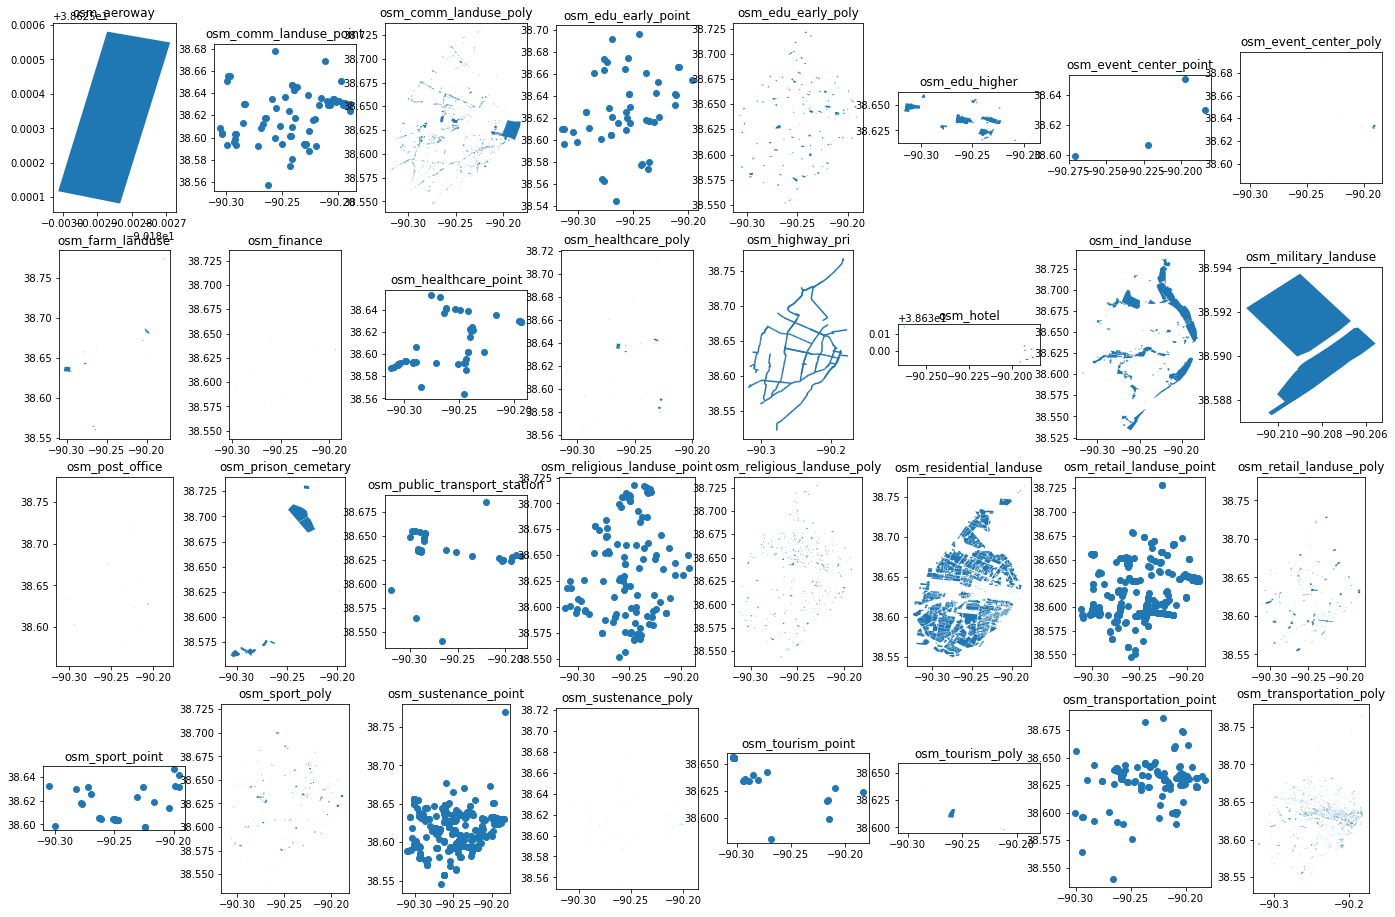

In [17]:
# creating numpy zeros array to access subplot location

a = np.zeros((4, 8))
b = []

for i, j in np.argwhere(a == 0):
    b.append([i, j])

# plot all GeoDataFrames to show distribution

y = 0
sl_column_dict = {}
fig, axs = plt.subplots(figsize=(24,16), ncols=8, nrows=4)

for l, v in osm_dict.items():
    k = gpd.read_file(v)    # read in GeoDataFrame
    k.plot(ax=axs[b[y][0]][b[y][1]])    # plot in provided location
    axs[b[y][0], b[y][1]].set_title(osm_dict_list[y])   # plot title
    sl_column_dict[osm_dict_list[y]] = k.columns    # dictionary of GeoDataFrame name and corresponding columns
    vars()[l] = k.copy()    # assign name to GeoDataFrame
    y+=1

In [18]:
# columns common to all GeoDataFrames
 
list_of_column_list = [sl_column_dict.get(i).tolist() for i in osm_dict_list]

list(set.intersection(*[set(list) for list in list_of_column_list]))

# list_of_column_list

['name', 'full_id', 'geometry', 'osm_id', 'osm_type']

<a id="six"></a>

<center>

## CENPY
Importing census data with cenpy

<a href=#linkme>*back to table of contents*</a>

<center>

In [17]:
# census data available through cenpy

explore = cen.explorer.available()
explore.columns

Index(['c_isMicrodata', 'c_isTimeseries', 'publisher', 'temporal', 'spatial',
       'programCode', 'modified', 'keyword', 'contactPoint', 'distribution',
       'description', 'bureauCode', 'accessLevel', 'title', 'c_isAvailable',
       'c_isCube', 'c_isAggregate', 'c_dataset', 'vintage'],
      dtype='object')

In [17]:
explore.head(2) 

,c_isTimeseries,c_isMicrodata,publisher,temporal,spatial,programCode,modified,keyword,contactPoint,distribution,description,bureauCode,accessLevel,title,c_isAvailable,c_isCube,c_isAggregate,c_dataset,vintage
NONEMP1999,NaN,NaN,U.S. Census Bureau,1999/1999,United States,006:007,2017-02-09,"(census,)","{'fn': 'Nonemployer Statistics staff', 'hasEma...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",Nonemployer Statistics is an annual series tha...,006:07,public,1999 Nonemployer Statistics: Non Employer Stat...,True,True,True,"(nonemp,)",1999.0
NONEMP1997,NaN,NaN,U.S. Census Bureau,1997/1997,United States,006:007,2017-02-09,"(census,)","{'fn': 'Nonemployer Statistics staff', 'hasEma...","{'@type': 'dcat:Distribution', 'accessURL': 'h...",Nonemployer Statistics is an annual series tha...,006:07,public,1997 Nonemployer Statistics: Non Employer Stat...,True,True,True,"(nonemp,)",1997.0


In [ ]:
explore.index

In [18]:
# extract ACS related data

acs_data = [i for i in explore.index if "ACS" in i]
acs_data 

['ACSSF5Y2009',
 'ACSDT1Y2010',
 'ACSCP1Y2010',
 'ACSDP1Y2010',
 'ACSST1Y2010',
 'ACSDT5Y2010',
 'ACSDP5Y2010',
 'ACSST5Y2010',
 'ACSFlows2010',
 'ACSCD1132011',
 'ACSDT1Y2011',
 'ACSCP1Y2011',
 'ACSDP1Y2011',
 'ACSST1Y2011',
 'ACSDT5Y2011',
 'ACSDP5Y2011',
 'ACSST5Y2011',
 'ACSFlows2011',
 'ACSDT1Y2012',
 'ACSFlows2012',
 'ACSCP1Y2012',
 'ACSDP1Y2012',
 'ACSST5Y2012',
 'ACSST1Y2012',
 'ACSDT5Y2012',
 'ACSDP5Y2012',
 'ACSDT5Y2013',
 'ACSDP1Y2013',
 'ACSCP1Y2013',
 'ACSFlows2013',
 'ACSDT1Y2013',
 'ACSST1Y2013',
 'ACSDP5Y2013',
 'ACSST5Y2013',
 'ACSLANG5Y2013',
 'ACSDT1Y2014',
 'ACSCP1Y2014',
 'ACSSE2014',
 'ACSDP1Y2014',
 'ACSST1Y2014',
 'ACSDT5Y2014',
 'ACSDP5Y2014',
 'ACSFlows2014',
 'ACSST5Y2014',
 'ACSCD1152015',
 'ACSDT1Y2015',
 'ACSDT5Y2015',
 'ACSCP1Y2015',
 'ACSCP5Y2015',
 'ACSST1Y2015',
 'ACSDP1Y2015',
 'ACSDP5Y2015',
 'ACSST5Y2015',
 'ACSSE2015',
 'ACSFlows2015',
 'ACSDT1Y2016',
 'ACSCP1Y2016',
 'ACSDP1Y2016',
 'ACSSPP1Y2016',
 'ACSST1Y2016',
 'ACSDT5Y2016',
 'ACSCP5Y2016',
 

In [19]:
# sort by year, showing only row index with "ACS" within it

explore_sort = explore[explore.index.isin(acs_data)][["description", "vintage"]].sort_values("vintage", ascending=False)

explore_sort.to_excel("data/explore.xlsx")

In [25]:
explore_sort.head()

,description,vintage
ACSST1Y2021,The American Community Survey (ACS) is a US-wi...,2021.0
ACSDT1Y2021,The American Community Survey (ACS) is an ongo...,2021.0
ACSDP1Y2021,The American Community Survey (ACS) is a US-wi...,2021.0
ACSCP1Y2021,The American Community Survey (ACS) is an ongo...,2021.0
ACSSPP1Y2021,Selected Population Profiles provide broad soc...,2021.0


In [132]:
# top row description

explore_sort.iloc[0][0]

"The American Community Survey (ACS) is a US-wide survey designed to provide communities a fresh look at how they are changing. The ACS replaced the decennial census long form in 2010 and thereafter by collecting long form type information throughout the decade rather than only once every 10 years. Questionnaires are mailed to a sample of addresses to obtain information about households -- that is, about each person and the housing unit itself. The American Community Survey produces demographic, social, housing and economic estimates in the form of 1 and 5-year estimates based on population thresholds. The strength of the ACS is in estimating population and housing characteristics. The data profiles provide key estimates for each of the topic areas covered by the ACS for the us, all 50 states, the District of Columbia, Puerto Rico, every congressional district, every metropolitan area, and all counties and places with populations of 65,000 or more. Although the ACS produces population,

In [ ]:
# investigate variables
# ACS data requesting apikey
# apikey=???
# DECENNIALSF12010 worked without apikey....why??

# cxn = cen.remote.APIConnection('ACSST5Y2020')
# explore_var = cxn.variables
# explore_var.columns

<a id="seven"></a>

<center>

## [UNITED STATES CENSUS BUREAU](https://www.census.gov) | [CENSUS REPORTER](https://censusreporter.org)
Importing data from census websites

<a href=#linkme>*back to table of contents*</a>

<center>

<a id="seven_one"></a>
### Region population

<a href=#seven>*back to United States Census Bureau | Census Reporter*</a>

In [19]:
# read in GeoDataFrame of region population

st_louis_pop0 = gpd.read_file("data/Geo data/census Sex by Age.geojson")
st_louis_pop0.shape

(105, 101)

In [20]:
st_louis_pop0.sample()  # random row

,geoid,name,B01001001,"B01001001, Error",B01001002,"B01001002, Error",B01001003,"B01001003, Error",B01001004,"B01001004, Error",...,"B01001045, Error",B01001046,"B01001046, Error",B01001047,"B01001047, Error",B01001048,"B01001048, Error",B01001049,"B01001049, Error",geometry
45,14000US29510111100,"Census Tract 1111, St. Louis, MO",1821.0,391.0,911.0,261.0,83.0,81.0,65.0,65.0,...,27.0,58.0,40.0,10.0,11.0,7.0,14.0,22.0,14.0,"MULTIPOLYGON (((-90.25265 38.65135, -90.25261 ..."


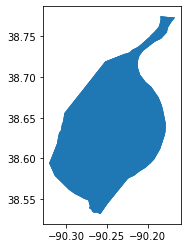

In [21]:
# plot nth random row(s) over the entire region

nth = 50
fig, axs = plt.subplots(ncols=1, nrows=1)

st_louis_pop0.plot(ax=axs)
st_louis_pop0.sample(nth).plot(ax=axs)
plt.show()

In [40]:
# change coordinate reference system (crs) to New York State Plane Long Island Zone (EPSG 2263) to access centroids
# it provides a high degree of accuracy and balances size and shape well

# pip install pyproj

st_louis_pop0 = st_louis_pop0.to_crs(epsg=2263)

# Access the centroid attribute of each polygon

st_louis_pop0['centroid'] = st_louis_pop0.centroid

In [41]:
# convert back to latitude/longitude coordinate system (EPSG 4326)


st_louis_pop0 = st_louis_pop0.to_crs(epsg=4326)

st_louis_pop0['centroid'] = st_louis_pop0['centroid'].to_crs(epsg=4326)

C:\Users\Ejiwunmi\Anaconda\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


AttributeError: 'Series' object has no attribute 'to_crs'

In [42]:
st_louis_pop0.head(1)

,geoid,name,total,"B01001001, Error",total_male,"B01001002, Error",B01001003,"B01001003, Error",B01001004,"B01001004, Error",...,B01001048,"B01001048, Error",B01001049,"B01001049, Error",geometry,total_children_under14,total_youth_15_24,total_adult_25_64,total_seniors_65above,centroid
0,14000US29510101100,"Census Tract 1011, St. Louis, MO",2391.0,307.0,1142.0,121.0,70.0,48.0,61.0,32.0,...,29.0,34.0,41.0,30.0,"MULTIPOLYGON (((-90.28695 38.55552, -90.28692 ...",288.0,218.0,1468.0,417.0,POINT (-3646841.045 -155839.471)


In [43]:
# list of columns for segmenting total population by age

children_under14 = ['B01001003',
 'B01001004',
 'B01001005',
 'B01001027',
 'B01001028',
 'B01001029']
youth_15_24 = ['B01001006',
 'B01001007',
 'B01001008',
 'B01001009',
 'B01001010',
 'B01001030',
 'B01001031',
 'B01001032',
 'B01001033',
 'B01001034']
adult_25_64 = ['B01001011',
 'B01001012',
 'B01001013',
 'B01001014',
 'B01001015',
 'B01001016',
 'B01001017',
 'B01001018',
 'B01001019',
 'B01001035',
 'B01001036',
 'B01001037',
 'B01001038',
 'B01001039',
 'B01001040',
 'B01001041',
 'B01001042',
 'B01001043']
seniors_65above = ['B01001020',
 'B01001021',
 'B01001022',
 'B01001023',
 'B01001024',
 'B01001025',
 'B01001044',
 'B01001045',
 'B01001046',
 'B01001047',
 'B01001048',
 'B01001049']

In [44]:
# aggregate by age

st_louis_pop0["total_children_under14"] = st_louis_pop0[children_under14].sum(axis=1)
st_louis_pop0["total_youth_15_24"] = st_louis_pop0[youth_15_24].sum(axis=1)
st_louis_pop0["total_adult_25_64"] = st_louis_pop0[adult_25_64].sum(axis=1)
st_louis_pop0["total_seniors_65above"] = st_louis_pop0[seniors_65above].sum(axis=1)

In [45]:
st_louis_pop0.columns

Index(['geoid', 'name', 'total', 'B01001001, Error', 'total_male',
       'B01001002, Error', 'B01001003', 'B01001003, Error', 'B01001004',
       'B01001004, Error',
       ...
       'B01001048', 'B01001048, Error', 'B01001049', 'B01001049, Error',
       'geometry', 'total_children_under14', 'total_youth_15_24',
       'total_adult_25_64', 'total_seniors_65above', 'centroid'],
      dtype='object', length=106)

In [48]:
# dictionary of columns to rename

col_rename_sl = {'B01001001': 'total',
 'B01001002': 'total_male',
 'B01001026': 'total_female'}

st_louis_pop0.rename(columns=col_rename_sl, inplace=True)

In [49]:
st_louis_pop0['centroid']

0      POINT (-3646841.045 -155839.471)
1      POINT (-3646497.903 -153394.086)
2      POINT (-3643139.870 -152218.606)
3      POINT (-3640423.769 -154329.496)
4      POINT (-3644616.396 -158658.742)
                     ...               
100    POINT (-3623212.247 -129651.527)
101    POINT (-3622422.300 -142154.993)
102    POINT (-3627345.685 -123181.767)
103    POINT (-3627980.980 -130813.115)
104    POINT (-3633115.710 -128418.029)
Name: centroid, Length: 105, dtype: geometry

In [50]:
# create DataFrame with choice columns

# st_louis_pop1 = st_louis_pop0[["geoid", "name", "geometry",
#     "total", "total_male", "total_female", "total_children_under14",
#     "total_youth_15_24", "total_adult_25_64", "total_seniors_65above"]]

st_louis_pop1 = st_louis_pop0[["geoid", "name", "geometry", "centroid",
    "total", "total_male", "total_female", "total_children_under14",
    "total_youth_15_24", "total_adult_25_64", "total_seniors_65above"]]

In [51]:
st_louis_pop1.tail()

,geoid,name,geometry,centroid,total,total_male,total_female,total_children_under14,total_youth_15_24,total_adult_25_64,total_seniors_65above
100,14000US29510127500,"Census Tract 1275, St. Louis, MO","MULTIPOLYGON (((-90.21853 38.63329, -90.21844 ...",POINT (-3623212.247 -129651.527),2025.0,975.0,1050.0,177.0,223.0,1337.0,288.0
101,14000US29510127600,"Census Tract 1276, St. Louis, MO","MULTIPOLYGON (((-90.21346 38.60031, -90.21336 ...",POINT (-3622422.300 -142154.993),2418.0,1389.0,1029.0,153.0,300.0,1693.0,272.0
102,14000US29510127700,"Census Tract 1277, St. Louis, MO","MULTIPOLYGON (((-90.23843 38.65102, -90.23821 ...",POINT (-3627345.685 -123181.767),2271.0,1192.0,1079.0,247.0,503.0,918.0,603.0
103,14000US29510127800,"Census Tract 1278, St. Louis, MO","MULTIPOLYGON (((-90.23665 38.62618, -90.23655 ...",POINT (-3627980.980 -130813.115),3513.0,1597.0,1916.0,292.0,1567.0,1144.0,510.0
104,16000US2965000,"St. Louis, MO","MULTIPOLYGON (((-90.32052 38.59415, -90.32050 ...",POINT (-3633115.710 -128418.029),304709.0,147692.0,157017.0,49787.0,36328.0,176982.0,41612.0


In [52]:
# delete row with sum of each attributes for all census tract; the last row

st_louis_pop2 = st_louis_pop1.drop(st_louis_pop1.tail(1).index)

st_louis_pop2.shape

(104, 11)

In [53]:
st_louis_popf = st_louis_pop2.copy()

<a id="seven_two"></a>
### Household, economic and social characteristics

<a href=#seven>*back to United States Census Bureau | Census Reporter*</a>

In [54]:
# dictionary of names of GeoDataFrames and their corresponding location on file

census_dìct = {
    "economic0": "data/Geo data/census economic xtics.csv",
    "housing0": "data/Geo data/census housing xtics.csv",
    "social0": "data/Geo data/census social xtics.csv"
    }

# extracting dictionary keys into a list

census_dict_list = list(census_dìct.keys())
census_dict_list

['economic0', 'housing0', 'social0']

In [55]:
# read in data of household, economic and social characteristics

for l, v in census_dìct.items():
    h = pd.read_csv(v).fillna(0)
#     print(h)

    # replace string in census tract name to reflect existing pattern
    # shift census tract name to align with its features
    h["name"] = h["Label (Grouping)"].str.replace("St. Louis city, Missouri", "St. Louis, MO", regex=False).shift(1)

    # delete previous name column
    h.drop(h[h["Label (Grouping)"].str.contains("Percent|Census")==True].index, inplace=True)

    h.reset_index(drop=True, inplace=True)  # reset index

    # delete white noise columns; columns with single value across tracts
    unique = pd.DataFrame(h.nunique())  # extract unique values of each column
    h.drop(unique[unique[0]==1].index, axis=1, inplace=True)    # delete one value columns

    # convert numbers with dtype object to int 
    for j in h.select_dtypes(["object"]).columns:
        h[j] = h[j].astype("str")   # change dtype to str

        # name is a column with dtype object but not a number
        if j != "name":
            h[j] = h[j].str.replace(",", "")    # remove commas from numbers
            h[j] = pd.to_numeric(h[j], errors="coerce") # change dtype to int
            
    vars()[l] = h.copy()


In [52]:
social0.head()    # random row

,HOUSEHOLDS BY TYPE!!Total households,HOUSEHOLDS BY TYPE!!Total households!!Married-couple household,HOUSEHOLDS BY TYPE!!Total households!!Cohabiting couple household,"HOUSEHOLDS BY TYPE!!Total households!!Male householder, no spouse/partner present","HOUSEHOLDS BY TYPE!!Total households!!Male householder, no spouse/partner present!!Householder living alone","HOUSEHOLDS BY TYPE!!Total households!!Male householder, no spouse/partner present!!Householder living alone!!65 years and over","HOUSEHOLDS BY TYPE!!Total households!!Female householder, no spouse/partner present","HOUSEHOLDS BY TYPE!!Total households!!Female householder, no spouse/partner present!!Householder living alone","HOUSEHOLDS BY TYPE!!Total households!!Female householder, no spouse/partner present!!Householder living alone!!65 years and over",HOUSEHOLDS BY TYPE!!Total households!!Households with one or more people under 18 years,...,ANCESTRY!!Total population!!Subsaharan African,ANCESTRY!!Total population!!Swedish,ANCESTRY!!Total population!!Swiss,ANCESTRY!!Total population!!Ukrainian,ANCESTRY!!Total population!!Welsh,ANCESTRY!!Total population!!West Indian (excluding Hispanic origin groups),COMPUTERS AND INTERNET USE!!Total households,COMPUTERS AND INTERNET USE!!Total households!!With a computer,COMPUTERS AND INTERNET USE!!Total households!!With a broadband Internet subscription,name
0,1041,409,111,239,192,48,282,127,71,261,...,0,10,11,8,0,0,1041,927,866,"Census Tract 1011, St. Louis, MO"
1,1427,739,142,215,175,49,331,246,115,399,...,0,8,9,0,12,0,1427,1296,1220,"Census Tract 1012, St. Louis, MO"
2,1911,745,101,368,315,131,697,636,145,376,...,43,28,1,11,0,0,1911,1691,1698,"Census Tract 1013, St. Louis, MO"
3,1138,460,30,306,250,53,342,139,109,432,...,94,9,0,0,18,0,1138,1021,964,"Census Tract 1014, St. Louis, MO"
4,1347,206,224,464,422,119,453,148,26,361,...,175,8,0,0,0,0,1347,998,894,"Census Tract 1015, St. Louis, MO"


In [56]:
# column of choice among economic characteristics

economic0_columns = ['EMPLOYMENT STATUS!!Population 16 years and over',
 'EMPLOYMENT STATUS!!Population 16 years and over!!In labor force',
 'EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force',
 'EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed',
 'EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed',
 'EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Armed Forces',
 'EMPLOYMENT STATUS!!Population 16 years and over!!Not in labor force',
 'COMMUTING TO WORK!!Workers 16 years and over',
 'COMMUTING TO WORK!!Workers 16 years and over!!Car, truck, or van -- drove alone',
 'COMMUTING TO WORK!!Workers 16 years and over!!Car, truck, or van -- carpooled',
 'COMMUTING TO WORK!!Workers 16 years and over!!Public transportation (excluding taxicab)',
 'COMMUTING TO WORK!!Workers 16 years and over!!Walked',
 'COMMUTING TO WORK!!Workers 16 years and over!!Other means',
 'COMMUTING TO WORK!!Workers 16 years and over!!Worked from home',
 'COMMUTING TO WORK!!Workers 16 years and over!!Mean travel time to work (minutes)',
 'INCOME AND BENEFITS (IN 2020 INFLATION-ADJUSTED DOLLARS)!!Total households',
 'INCOME AND BENEFITS (IN 2020 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)',
 'INCOME AND BENEFITS (IN 2020 INFLATION-ADJUSTED DOLLARS)!!Total households!!Mean household income (dollars)',
 'INCOME AND BENEFITS (IN 2020 INFLATION-ADJUSTED DOLLARS)!!Total households!!With earnings!!Mean earnings (dollars)',
 'INCOME AND BENEFITS (IN 2020 INFLATION-ADJUSTED DOLLARS)!!Families',
 'INCOME AND BENEFITS (IN 2020 INFLATION-ADJUSTED DOLLARS)!!Families!!Mean family income (dollars)',
 'INCOME AND BENEFITS (IN 2020 INFLATION-ADJUSTED DOLLARS)!!Per capita income (dollars)',
 'name']

In [57]:
# column of choice among housing characteristics

housing0_columns = ['HOUSING OCCUPANCY!!Total housing units',
 'HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
 'HOUSING OCCUPANCY!!Total housing units!!Vacant housing units',
 'HOUSING OCCUPANCY!!Total housing units!!Homeowner vacancy rate',
 'HOUSING OCCUPANCY!!Total housing units!!Rental vacancy rate',
 'GROSS RENT!!Occupied units paying rent',
 'GROSS RENT!!Occupied units paying rent!!Median (dollars)',
 'GROSS RENT!!Occupied units paying rent!!No rent paid',
 'name']

In [58]:
# column of choice among social characteristics

social0_columns = ['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school',
 'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school, preschool',
 'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten',
 'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)',
 'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)',
 'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school',
 'EDUCATIONAL ATTAINMENT!!Population 25 years and over',
 'EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Less than 9th grade',
 'EDUCATIONAL ATTAINMENT!!Population 25 years and over!!9th to 12th grade, no diploma',
 'EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate (includes equivalency)',
 'EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college, no degree',
 "EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Associate's degree",
 "EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree",
 'EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Graduate or professional degree',
 'EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate or higher',
 "EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher",
 'COMPUTERS AND INTERNET USE!!Total households',
 'COMPUTERS AND INTERNET USE!!Total households!!With a computer',
 'COMPUTERS AND INTERNET USE!!Total households!!With a broadband Internet subscription',
 'name']

In [59]:
# merge all choice columns into one DataFrame

census_dataframes = [economic0[economic0_columns], housing0[housing0_columns], social0[social0_columns]]

census_merged = reduce(lambda  left,right: pd.merge(left,right,on=["name"], how='outer'), census_dataframes)

In [60]:
# dictionary to rename columns with apostrophe within name

census_rename_dict = {"EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Associate's degree": 'EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Associate degree',
    "EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree": 'EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor degree',
    "EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher": 'EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor degree or higher'}

In [61]:
census_merged.rename(columns = census_rename_dict, inplace = True)  # rename columns

In [62]:
census_merged.sample()  # random row

,EMPLOYMENT STATUS!!Population 16 years and over,EMPLOYMENT STATUS!!Population 16 years and over!!In labor force,EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force,EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed,EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed,EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Armed Forces,EMPLOYMENT STATUS!!Population 16 years and over!!Not in labor force,COMMUTING TO WORK!!Workers 16 years and over,"COMMUTING TO WORK!!Workers 16 years and over!!Car, truck, or van -- drove alone","COMMUTING TO WORK!!Workers 16 years and over!!Car, truck, or van -- carpooled",...,EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate (includes equivalency),"EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college, no degree",EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Associate degree,EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor degree,EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Graduate or professional degree,EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate or higher,EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor degree or higher,COMPUTERS AND INTERNET USE!!Total households,COMPUTERS AND INTERNET USE!!Total households!!With a computer,COMPUTERS AND INTERNET USE!!Total households!!With a broadband Internet subscription
69,3378,2708,2708,2611,97,0,670,2598,1884,366,...,470,682,121,636,795,2704,1431,1686,1581,1437


In [63]:
census_mergedf = census_merged.copy()

census_mergedf.shape

(104, 50)

<a id="seven_three"></a>
### Merge census data

<a href=#seven>*back to United States Census Bureau | Census Reporter*</a>

In [64]:
census_data = st_louis_popf.merge(census_mergedf, on="name")    # merge population data with characteristics data

census_data.shape

(104, 60)

<a id="seven_four"></a>
### Check data integrity

<a href=#seven>*back to United States Census Bureau | Census Reporter*</a>

In [65]:
census_data.isnull().sum().sum()    # check for null values

0

In [66]:
# pick a row at random

random_block = census_data.sample()
random_block

,geoid,name,geometry,centroid,total,total_male,total_female,total_children_under14,total_youth_15_24,total_adult_25_64,...,EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate (includes equivalency),"EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Some college, no degree",EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Associate degree,EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor degree,EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Graduate or professional degree,EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate or higher,EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor degree or higher,COMPUTERS AND INTERNET USE!!Total households,COMPUTERS AND INTERNET USE!!Total households!!With a computer,COMPUTERS AND INTERNET USE!!Total households!!With a broadband Internet subscription
37,14000US29510108300,"Census Tract 1083, St. Louis, MO","MULTIPOLYGON (((-90.24067 38.72259, -90.24067 ...",POINT (-3623966.630 -97934.396),2072.0,870.0,1202.0,463.0,357.0,980.0,...,467,276,95,59,81,978,140,858,721,557


In [67]:
# check total population with sub groups

print('Total population: ' + str(random_block.iloc[0]['total']))
print('Male + Female: ' + str(random_block.iloc[0]['total_male'] + random_block.iloc[0]['total_female']))
print('children + youth + adult + senior: ' + str(random_block.iloc[0]['total_children_under14']
    + random_block.iloc[0]['total_youth_15_24'] + random_block.iloc[0]['total_adult_25_64']
    + random_block.iloc[0]['total_seniors_65above']))

Total population: 2072.0
Male + Female: 2072.0
children + youth + adult + senior: 2072.0


In [68]:
# check total enrollments with sub groups

print('Total Enrollment: ' + str(random_block.iloc[0]['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school']))
print('Nursery & Preschool + Kindergarten + Elementary school + High School + College & Graduate SChool: '
    + str(random_block.iloc[0]['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Nursery school, preschool']
    + random_block.iloc[0]['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Kindergarten']
    + random_block.iloc[0]['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!Elementary school (grades 1-8)']
    + random_block.iloc[0]['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!High school (grades 9-12)']
    + random_block.iloc[0]['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school']))

Total Enrollment: 543
Nursery & Preschool + Kindergarten + Elementary school + High School + College & Graduate SChool: 543


In [69]:
# check total housing units with sub groups

print('Total housing units: ' + str(random_block.iloc[0]['HOUSING OCCUPANCY!!Total housing units']))
print('Occupied + vacant: ' + str(random_block.iloc[0]['HOUSING OCCUPANCY!!Total housing units!!Occupied housing units']
    + random_block.iloc[0]['HOUSING OCCUPANCY!!Total housing units!!Vacant housing units']))

Total housing units: 1106
Occupied + vacant: 1106


<a id="eight"></a>

<center>

## SPATIAL JOIN
Merging geometry objects based on their spatial relationship

<a href=#linkme>*back to table of contents*</a>

<center>

<a id="eight_one"></a>
### Merge region attributes

<a href=#eight>*back to spatial join*</a>

In [94]:
# new name list for generated DataFrames showing count of each OSM object
print(census_data)
osm_dict_list_new = [i+"_trim" for i in osm_dict_list]

# count of each OSM object within a census tract

r = 0
compare_shape = []

for k in osm_dict_list_new:
    u = osm_dict_list[r]
#     print(vars()[u][['geometry']])
    j = gpd.sjoin(vars()[u][['geometry']], census_data)   # join geometry from each OSM GeoDataFrame to census_data
    print(j)
    compare_shape.append(j.shape)       # list to confirm that all generated DataFrames have equal number of columns
    m = j[['geoid', 'index_right']].groupby('geoid').agg('count').rename(columns={"index_right": u})    # count of OSM object in each tract
    vars()[k] = m.copy()
#     print(vars()[k])
    r+=1

                  geoid                              name  \
0    14000US29510101100  Census Tract 1011, St. Louis, MO   
1    14000US29510101200  Census Tract 1012, St. Louis, MO   
2    14000US29510101300  Census Tract 1013, St. Louis, MO   
3    14000US29510101400  Census Tract 1014, St. Louis, MO   
4    14000US29510101500  Census Tract 1015, St. Louis, MO   
..                  ...                               ...   
99   14000US29510127400  Census Tract 1274, St. Louis, MO   
100  14000US29510127500  Census Tract 1275, St. Louis, MO   
101  14000US29510127600  Census Tract 1276, St. Louis, MO   
102  14000US29510127700  Census Tract 1277, St. Louis, MO   
103  14000US29510127800  Census Tract 1278, St. Louis, MO   

                                              geometry  \
0    MULTIPOLYGON (((-90.28695 38.55552, -90.28692 ...   
1    MULTIPOLYGON (((-90.28291 38.55984, -90.28262 ...   
2    MULTIPOLYGON (((-90.27362 38.56990, -90.27331 ...   
3    MULTIPOLYGON (((-90.25961 38.5

C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


                                               geometry  index_right  \
0     MULTIPOLYGON (((-90.25308 38.63476, -90.25315 ...           74   
126   MULTIPOLYGON (((-90.25719 38.63353, -90.25734 ...           74   
127   MULTIPOLYGON (((-90.25236 38.62803, -90.25283 ...           74   
128   MULTIPOLYGON (((-90.25234 38.62794, -90.25267 ...           74   
129   MULTIPOLYGON (((-90.25240 38.62821, -90.25221 ...           74   
...                                                 ...          ...   
1342  MULTIPOLYGON (((-90.26447 38.58334, -90.26445 ...           59   
1343  MULTIPOLYGON (((-90.26393 38.58316, -90.26435 ...           59   
1344  MULTIPOLYGON (((-90.26313 38.58366, -90.26362 ...           59   
1374  MULTIPOLYGON (((-90.24975 38.58329, -90.24956 ...           59   
1379  MULTIPOLYGON (((-90.25454 38.57516, -90.25437 ...           59   

                   geoid                              name  \
0     14000US29510118600  Census Tract 1186, St. Louis, MO   
126   14000

C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


                     geometry  index_right               geoid  \
0  POINT (-90.27081 38.59905)           55  14000US29510114200   
1  POINT (-90.19756 38.65066)           91  14000US29510126600   
2  POINT (-90.18452 38.62979)           89  14000US29510125600   
3  POINT (-90.22243 38.60659)           83  14000US29510123300   

                               name                          centroid   total  \
0  Census Tract 1142, St. Louis, MO  POINT (-3646908.518 -139634.907)  4046.0   
1  Census Tract 1266, St. Louis, MO  POINT (-3616928.855 -126690.362)  2839.0   
2  Census Tract 1256, St. Louis, MO  POINT (-3617783.017 -134371.133)  5438.0   
3  Census Tract 1233, St. Louis, MO  POINT (-3627224.464 -140713.113)  2951.0   

   total_male  total_female  total_children_under14  total_youth_15_24  ...  \
0      1811.0        2235.0                   391.0              190.0  ...   
1      1378.0        1461.0                   779.0              345.0  ...   
2      3464.0        1974.

C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


                      geometry  index_right               geoid  \
0   POINT (-90.23905 38.62297)           98  14000US29510127300   
1   POINT (-90.23928 38.62144)           98  14000US29510127300   
3   POINT (-90.24008 38.62326)           98  14000US29510127300   
4   POINT (-90.23757 38.62210)           98  14000US29510127300   
6   POINT (-90.24023 38.61559)           98  14000US29510127300   
35  POINT (-90.23845 38.62453)           98  14000US29510127300   
2   POINT (-90.27593 38.65389)           49  14000US29510112200   
22  POINT (-90.26731 38.65215)           49  14000US29510112200   
5   POINT (-90.26355 38.63768)           51  14000US29510112400   
11  POINT (-90.26202 38.64235)           51  14000US29510112400   
7   POINT (-90.24357 38.59585)           66  14000US29510116301   
17  POINT (-90.24265 38.60172)           66  14000US29510116301   
8   POINT (-90.19435 38.62895)           89  14000US29510125600   
9   POINT (-90.19590 38.63038)           89  14000US2951012560

C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


                                              geometry  index_right  \
0    LINESTRING (-90.22040 38.63113, -90.21976 38.6...          103   
10   LINESTRING (-90.23378 38.63443, -90.23381 38.6...          103   
16   LINESTRING (-90.23378 38.63443, -90.23375 38.6...          103   
29   LINESTRING (-90.21756 38.62765, -90.21752 38.6...          103   
66   LINESTRING (-90.22768 38.63111, -90.22789 38.6...          103   
..                                                 ...          ...   
643  LINESTRING (-90.28055 38.66547, -90.28098 38.6...           22   
644  LINESTRING (-90.27967 38.66499, -90.28013 38.6...           22   
645  LINESTRING (-90.27879 38.66452, -90.27967 38.6...           22   
647  LINESTRING (-90.27257 38.66117, -90.27278 38.6...           22   
658  LINESTRING (-90.26371 38.65048, -90.26362 38.6...           49   

                  geoid                              name  \
0    14000US29510127800  Census Tract 1278, St. Louis, MO   
10   14000US29510127800  

C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


                                              geometry  index_right  \
0    MULTIPOLYGON (((-90.19046 38.66120, -90.19072 ...           92   
2    MULTIPOLYGON (((-90.21531 38.68726, -90.21559 ...           92   
8    MULTIPOLYGON (((-90.19461 38.65921, -90.19479 ...           92   
32   MULTIPOLYGON (((-90.20387 38.65966, -90.20389 ...           92   
34   MULTIPOLYGON (((-90.20389 38.66222, -90.20598 ...           92   
..                                                 ...          ...   
139  MULTIPOLYGON (((-90.25682 38.71457, -90.25684 ...           31   
144  MULTIPOLYGON (((-90.22981 38.60322, -90.22991 ...           85   
146  MULTIPOLYGON (((-90.23367 38.59849, -90.23341 ...           69   
147  MULTIPOLYGON (((-90.23442 38.59812, -90.23486 ...           69   
160  MULTIPOLYGON (((-90.24657 38.65167, -90.24655 ...           45   

                  geoid                              name  \
0    14000US29510126700  Census Tract 1267, St. Louis, MO   
2    14000US29510126700  

C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


                      geometry  index_right               geoid  \
0   POINT (-90.30038 38.64931)           18  14000US29510105198   
2   POINT (-90.29456 38.65566)           18  14000US29510105198   
24  POINT (-90.29431 38.65493)           18  14000US29510105198   
25  POINT (-90.29781 38.65528)           18  14000US29510105198   
1   POINT (-90.31942 38.59326)           15  14000US29510103800   
3   POINT (-90.26219 38.63592)           74  14000US29510118600   
16  POINT (-90.25147 38.63378)           74  14000US29510118600   
4   POINT (-90.28496 38.64782)           48  14000US29510112100   
12  POINT (-90.29114 38.63621)           48  14000US29510112100   
20  POINT (-90.28555 38.64456)           48  14000US29510112100   
26  POINT (-90.28831 38.63589)           48  14000US29510112100   
27  POINT (-90.28789 38.63387)           48  14000US29510112100   
28  POINT (-90.29199 38.63395)           48  14000US29510112100   
5   POINT (-90.23535 38.62950)          103  14000US2951012780

C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


                                              geometry  index_right  \
0    MULTIPOLYGON (((-90.25619 38.64770, -90.25609 ...           51   
1    MULTIPOLYGON (((-90.26411 38.64000, -90.26409 ...           51   
42   MULTIPOLYGON (((-90.25999 38.65073, -90.26016 ...           51   
109  MULTIPOLYGON (((-90.25535 38.64771, -90.25631 ...           51   
144  MULTIPOLYGON (((-90.25836 38.64997, -90.25784 ...           51   
..                                                 ...          ...   
646  MULTIPOLYGON (((-90.26388 38.59049, -90.26391 ...           58   
647  MULTIPOLYGON (((-90.26374 38.59059, -90.26374 ...           58   
648  MULTIPOLYGON (((-90.26274 38.59314, -90.26270 ...           58   
649  MULTIPOLYGON (((-90.26277 38.59309, -90.26279 ...           58   
650  MULTIPOLYGON (((-90.26330 38.59344, -90.26291 ...           58   

                  geoid                              name  \
0    14000US29510112400  Census Tract 1124, St. Louis, MO   
1    14000US29510112400  

C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


                                               geometry  index_right  \
0     MULTIPOLYGON (((-90.28460 38.62893, -90.28475 ...           17   
1664  MULTIPOLYGON (((-90.28375 38.62982, -90.28372 ...           17   
1768  MULTIPOLYGON (((-90.26633 38.62885, -90.26475 ...           17   
1769  MULTIPOLYGON (((-90.26645 38.62740, -90.26548 ...           17   
2010  MULTIPOLYGON (((-90.29406 38.62183, -90.29349 ...           17   
...                                                 ...          ...   
2423  MULTIPOLYGON (((-90.22554 38.59934, -90.22551 ...           85   
2424  MULTIPOLYGON (((-90.22472 38.60022, -90.22512 ...           85   
2425  MULTIPOLYGON (((-90.23013 38.59943, -90.23108 ...           85   
2426  MULTIPOLYGON (((-90.23107 38.60039, -90.23175 ...           85   
2427  MULTIPOLYGON (((-90.23209 38.60047, -90.23225 ...           85   

                   geoid                              name  \
0     14000US29510104500  Census Tract 1045, St. Louis, MO   
1664  14000

C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


                                              geometry  index_right  \
0    MULTIPOLYGON (((-90.29253 38.63631, -90.29247 ...           48   
48   MULTIPOLYGON (((-90.29013 38.63654, -90.29007 ...           48   
86   MULTIPOLYGON (((-90.26390 38.65123, -90.26421 ...           48   
304  MULTIPOLYGON (((-90.26480 38.65115, -90.26473 ...           48   
1    MULTIPOLYGON (((-90.20912 38.62966, -90.20913 ...           88   
..                                                 ...          ...   
442  MULTIPOLYGON (((-90.26799 38.61322, -90.26777 ...           52   
444  MULTIPOLYGON (((-90.26823 38.61645, -90.26796 ...           52   
447  MULTIPOLYGON (((-90.27511 38.61624, -90.27545 ...           52   
448  MULTIPOLYGON (((-90.27297 38.61482, -90.27275 ...           52   
491  MULTIPOLYGON (((-90.30923 38.58945, -90.30913 ...           11   

                  geoid                              name  \
0    14000US29510112100  Census Tract 1121, St. Louis, MO   
48   14000US29510112100  

C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


                       geometry  index_right               geoid  \
0    POINT (-90.29026 38.63544)           48  14000US29510112100   
1    POINT (-90.29203 38.63437)           48  14000US29510112100   
2    POINT (-90.29048 38.63482)           48  14000US29510112100   
3    POINT (-90.28925 38.63681)           48  14000US29510112100   
159  POINT (-90.29410 38.63390)           48  14000US29510112100   
..                          ...          ...                 ...   
333  POINT (-90.24631 38.64141)           76  14000US29510119102   
342  POINT (-90.24979 38.66563)           29  14000US29510106700   
373  POINT (-90.24700 38.56447)            3  14000US29510101400   
374  POINT (-90.25447 38.57518)           59  14000US29510115300   
376  POINT (-90.25453 38.56877)           60  14000US29510115400   

                                    name                          centroid  \
0       Census Tract 1121, St. Louis, MO  POINT (-3643191.092 -124819.660)   
1       Census Tract 1121, 

C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


                       geometry  index_right               geoid  \
0    POINT (-90.19065 38.63167)           89  14000US29510125600   
3    POINT (-90.19022 38.63154)           89  14000US29510125600   
4    POINT (-90.19015 38.63174)           89  14000US29510125600   
43   POINT (-90.19690 38.63021)           89  14000US29510125600   
66   POINT (-90.18508 38.63309)           89  14000US29510125600   
..                          ...          ...                 ...   
125  POINT (-90.30044 38.59995)           15  14000US29510103800   
130  POINT (-90.23739 38.68195)           94  14000US29510126900   
131  POINT (-90.24917 38.57641)           59  14000US29510115300   
133  POINT (-90.26960 38.60069)           65  14000US29510116200   
136  POINT (-90.28306 38.59200)           53  14000US29510114101   

                                    name                          centroid  \
0       Census Tract 1256, St. Louis, MO  POINT (-3617783.017 -134371.133)   
3       Census Tract 1256, 

C:\Users\Ejiwunmi\Anaconda\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


                                               geometry  index_right  \
0     MULTIPOLYGON (((-90.18814 38.63059, -90.18846 ...           89   
1     MULTIPOLYGON (((-90.19123 38.62877, -90.19113 ...           89   
25    MULTIPOLYGON (((-90.19542 38.62858, -90.19550 ...           89   
48    MULTIPOLYGON (((-90.19830 38.62336, -90.19769 ...           89   
49    MULTIPOLYGON (((-90.19468 38.62552, -90.19421 ...           89   
...                                                 ...          ...   
1635  MULTIPOLYGON (((-90.25210 38.71154, -90.25213 ...           31   
1636  MULTIPOLYGON (((-90.25234 38.71159, -90.25224 ...           31   
1847  MULTIPOLYGON (((-90.28665 38.61569, -90.28639 ...           13   
1955  MULTIPOLYGON (((-90.28743 38.61721, -90.28763 ...           13   
1931  MULTIPOLYGON (((-90.24560 38.68527, -90.24561 ...           34   

                   geoid                              name  \
0     14000US29510125600  Census Tract 1256, St. Louis, MO   
1     14000

In [84]:
# confirming column length of DataFrames

set([compare_shape[i][1] for i in range(len(compare_shape))])

{61}

<a id="eight_two"></a>
### Merge count of attribute

<a href=#eight>*back to spatial join*</a>

In [85]:
merged_data0 = census_data.copy()

# osm_dict_list_new
merged_data0.shape
# 

(104, 60)

In [82]:
# merge census data with OSM data

for i in osm_dict_list_new:
#     print(vars()[i])  
    merged_data0 = merged_data0.merge(vars()[i], on='geoid', how='outer').fillna(0)

                    osm_aeroway
geoid                          
14000US29510125600            1
                    osm_comm_landuse_point
geoid                                     
14000US29510101500                       1
14000US29510103400                       3
14000US29510103600                       1
14000US29510103700                       1
14000US29510104500                       2
14000US29510105198                       3
14000US29510106400                       1
14000US29510110500                       1
14000US29510111100                       3
14000US29510114101                       1
14000US29510114102                       2
14000US29510114200                       1
14000US29510115200                       1
14000US29510115500                       2
14000US29510116200                       1
14000US29510116301                       1
14000US29510116302                       1
14000US29510116500                       1
14000US29510117100                       3
1

In [76]:
merged_data0.columns

Index(['geoid', 'name', 'geometry', 'centroid', 'total', 'total_male',
       'total_female', 'total_children_under14', 'total_youth_15_24',
       'total_adult_25_64', 'total_seniors_65above',
       'EMPLOYMENT STATUS!!Population 16 years and over',
       'EMPLOYMENT STATUS!!Population 16 years and over!!In labor force',
       'EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force',
       'EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed',
       'EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed',
       'EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Armed Forces',
       'EMPLOYMENT STATUS!!Population 16 years and over!!Not in labor force',
       'COMMUTING TO WORK!!Workers 16 years and over',
       'COMMUTING TO WORK!!Workers 16 years and over!!Car, truck, or van -- drove alone',
       'COMMUTING TO WORK!!Workers 16 years and over!

In [77]:
  census_data.shape, merged_data0.shape # confirm that shape reflects merge

((104, 60), (104, 92))

In [78]:
# sum features with points and polygon objects

merged_data0["osm_comm_landuse"] = merged_data0.osm_comm_landuse_point + merged_data0.osm_comm_landuse_poly
merged_data0["osm_edu_early"] = merged_data0.osm_edu_early_point + merged_data0.osm_edu_early_poly
merged_data0["osm_event_center"] = merged_data0.osm_event_center_point + merged_data0.osm_event_center_poly
merged_data0["osm_healthcare"] = merged_data0.osm_healthcare_point + merged_data0.osm_healthcare_poly
merged_data0["osm_religious_landuse"] = merged_data0.osm_religious_landuse_point + merged_data0.osm_religious_landuse_poly
merged_data0["osm_retail_landuse"] = merged_data0.osm_retail_landuse_point + merged_data0.osm_retail_landuse_poly
merged_data0["osm_sport"] = merged_data0.osm_sport_point + merged_data0.osm_sport_poly
merged_data0["osm_sustenance"] = merged_data0.osm_sustenance_point + merged_data0.osm_sustenance_point
merged_data0["osm_tourism"] = merged_data0.osm_tourism_point + merged_data0.osm_tourism_poly
merged_data0["osm_transportation"] = merged_data0.osm_transportation_point + merged_data0.osm_transportation_poly

In [78]:
# drop unnecessary columns

merged_data1 = merged_data0.drop(columns=['osm_comm_landuse_point',
 'osm_comm_landuse_poly',
 'osm_edu_early_point',
 'osm_edu_early_poly',
 'osm_event_center_point',
 'osm_event_center_poly',
 'osm_healthcare_point',
 'osm_healthcare_poly',
 'osm_religious_landuse_point',
 'osm_religious_landuse_poly',
 'osm_retail_landuse_point',
 'osm_retail_landuse_poly',
 'osm_sport_point',
 'osm_sport_poly',
 'osm_sustenance_point',
 'osm_sustenance_poly',
 'osm_tourism_point',
 'osm_tourism_poly',
 'osm_transportation_point',
 'osm_transportation_poly'])

In [79]:
merged_data1.sample()   # random row

,geoid,name,geometry,centroid,total,total_male,total_female,total_children_under14,total_youth_15_24,total_adult_25_64,...,osm_comm_landuse,osm_edu_early,osm_event_center,osm_healthcare,osm_religious_landuse,osm_retail_landuse,osm_sport,osm_sustenance,osm_tourism,osm_transportation
48,14000US29510112100,"Census Tract 1121, St. Louis, MO","MULTIPOLYGON (((-90.30445 38.63282, -90.30441 ...",POINT (-3643191.092 -124819.660),3927.0,2029.0,1898.0,169.0,303.0,2731.0,...,9.0,1.0,0.0,0.0,13.0,10.0,83.0,32.0,10.0,39.0


In [80]:
merged_dataf = merged_data1.copy()
merged_dataf.to_csv('data/merged_data.csv')

In [81]:
_df2 = pd.read_csv("data/merged_data.csv")

_df2.head()

,Unnamed: 0,geoid,name,geometry,centroid,total,total_male,total_female,total_children_under14,total_youth_15_24,...,osm_comm_landuse,osm_edu_early,osm_event_center,osm_healthcare,osm_religious_landuse,osm_retail_landuse,osm_sport,osm_sustenance,osm_tourism,osm_transportation
0,0,14000US29510101100,"Census Tract 1011, St. Louis, MO","MULTIPOLYGON (((-90.286953 38.55552200000003, ...",POINT (-3646841.044531376 -155839.4707763521),2391.0,1142.0,1249.0,288.0,218.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,14000US29510101200,"Census Tract 1012, St. Louis, MO","MULTIPOLYGON (((-90.28291 38.55984000000001, -...",POINT (-3646497.902788972 -153394.0857113454),3626.0,2063.0,1563.0,844.0,237.0,...,3.0,2.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,6.0
2,2,14000US29510101300,"Census Tract 1013, St. Louis, MO","MULTIPOLYGON (((-90.273618 38.56990400000003, ...",POINT (-3643139.86954045 -152218.606194359),3712.0,1638.0,2074.0,538.0,268.0,...,6.0,1.0,0.0,0.0,8.0,1.0,1.0,0.0,0.0,12.0
3,3,14000US29510101400,"Census Tract 1014, St. Louis, MO","MULTIPOLYGON (((-90.259609 38.562502, -90.2594...",POINT (-3640423.76919232 -154329.4964500791),2834.0,1708.0,1126.0,565.0,473.0,...,5.0,1.0,0.0,0.0,5.0,4.0,0.0,2.0,0.0,3.0
4,4,14000US29510101500,"Census Tract 1015, St. Louis, MO",MULTIPOLYGON (((-90.27266400000001 38.54859600...,POINT (-3644616.395503598 -158658.7424698184),3065.0,1650.0,1415.0,417.0,389.0,...,2.0,3.0,0.0,0.0,6.0,11.0,0.0,12.0,0.0,8.0


In [82]:
# list of columns containing location information

base_cols = ['geoid', 'name', 'geometry', 'centroid']

# other columns

other_cols = [i for i in merged_dataf.columns if i not in base_cols]

<a id="nine"></a>

<center>

## GEOVISUALIZATION
Visualizing some features in the dataset

<a href=#linkme>*back to table of contents*</a>

<center>

In [83]:
describe = merged_data1.copy()

In [84]:
describe.describe() # describe DataFrame

,total,total_male,total_female,total_children_under14,total_youth_15_24,total_adult_25_64,total_seniors_65above,EMPLOYMENT STATUS!!Population 16 years and over,EMPLOYMENT STATUS!!Population 16 years and over!!In labor force,EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force,...,osm_comm_landuse,osm_edu_early,osm_event_center,osm_healthcare,osm_religious_landuse,osm_retail_landuse,osm_sport,osm_sustenance,osm_tourism,osm_transportation
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,...,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,2929.894231,1420.115385,1509.778846,478.721154,349.307692,1701.750000,400.115385,2424.500000,1614.134615,1607.663462,...,14.057692,1.682692,0.125000,0.721154,8.096154,8.134615,3.942308,7.326923,0.221154,20.221154
std,1224.581069,650.080851,631.618432,308.036578,286.862677,789.455555,224.882593,1033.790574,814.305840,809.272508,...,12.947112,1.620646,0.360353,1.375632,6.132073,8.948675,9.042324,15.365099,1.087946,29.886828
min,899.000000,364.000000,387.000000,70.000000,48.000000,506.000000,58.000000,743.000000,403.000000,403.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1935.750000,882.000000,1002.750000,250.000000,190.750000,1033.750000,249.000000,1633.250000,868.000000,868.000000,...,4.000000,0.750000,0.000000,0.000000,4.000000,2.000000,0.000000,0.000000,0.000000,4.000000
50%,2808.000000,1358.500000,1434.000000,392.000000,268.500000,1653.500000,368.000000,2259.000000,1571.000000,1547.000000,...,9.500000,1.000000,0.000000,0.000000,7.000000,5.500000,1.000000,2.000000,0.000000,10.000000
75%,3804.750000,1852.500000,1924.250000,648.500000,412.500000,2198.500000,512.000000,3223.500000,2173.000000,2173.000000,...,20.250000,2.000000,0.000000,1.000000,12.000000,11.250000,5.250000,8.000000,0.000000,22.000000
max,6363.000000,3464.000000,3357.000000,1887.000000,1760.000000,4063.000000,1368.000000,5090.000000,4051.000000,3943.000000,...,59.000000,9.000000,2.000000,6.000000,30.000000,38.000000,83.000000,126.000000,10.000000,154.000000


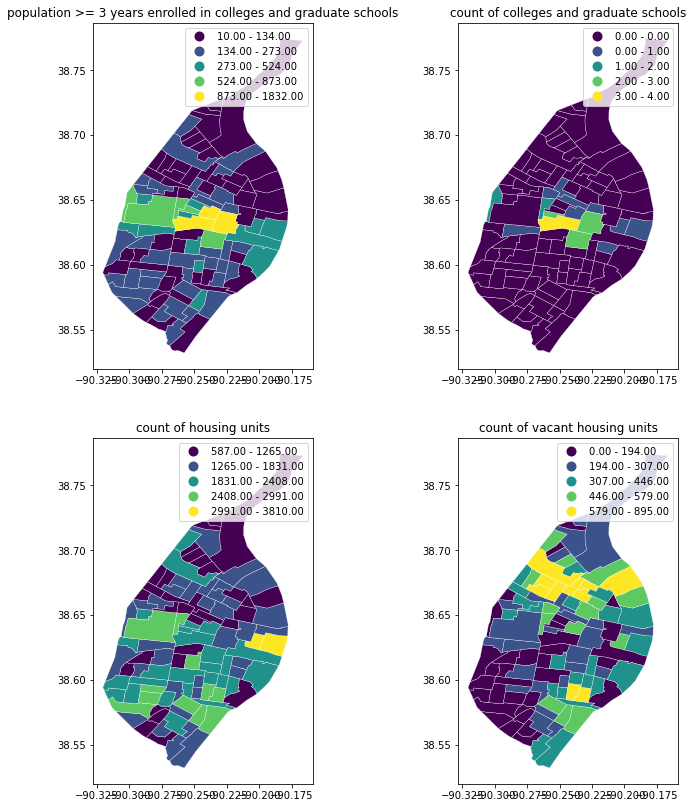

In [85]:
# subplot to compare market and competition of student accommodation

f, ax = plt.subplots(figsize=(12,14), ncols=2, nrows=2)
describe.plot(column='SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school',
        scheme='FisherJenks', ax=ax[0][0], edgecolor='white', legend=True, linewidth=0.3)
ax[0][0].set_title("population >= 3 years enrolled in colleges and graduate schools")
describe.plot(column='osm_edu_higher', scheme='FisherJenks', ax=ax[0][1], edgecolor='white', legend=True, linewidth=0.3)
ax[0][1].set_title("count of colleges and graduate schools")
describe.plot(column='HOUSING OCCUPANCY!!Total housing units', scheme='FisherJenks', ax=ax[1][0],
        edgecolor='white', legend=True, linewidth=0.3)
ax[1][0].set_title("count of housing units")
describe.plot(column='HOUSING OCCUPANCY!!Total housing units!!Vacant housing units',
        scheme='FisherJenks', ax=ax[1][1], edgecolor='white', legend=True, linewidth=0.3)
ax[1][1].set_title("count of vacant housing units")
plt.show()

# Save the full figure

# f.savefig("output/school_hostel.png")

# Save just the portion _inside_ the second axis's boundaries
# and pad the saved area by 10% in the x-direction and 20% in the y-direction

# extent = ax[0][0].get_window_extent().transformed(f.dpi_scale_trans.inverted())
# f.savefig("output/ax00_school_hostel.png", bbox_inches=extent.expanded(1.1, 1.2))

AttributeError: 'dict' object has no attribute 'to_string'

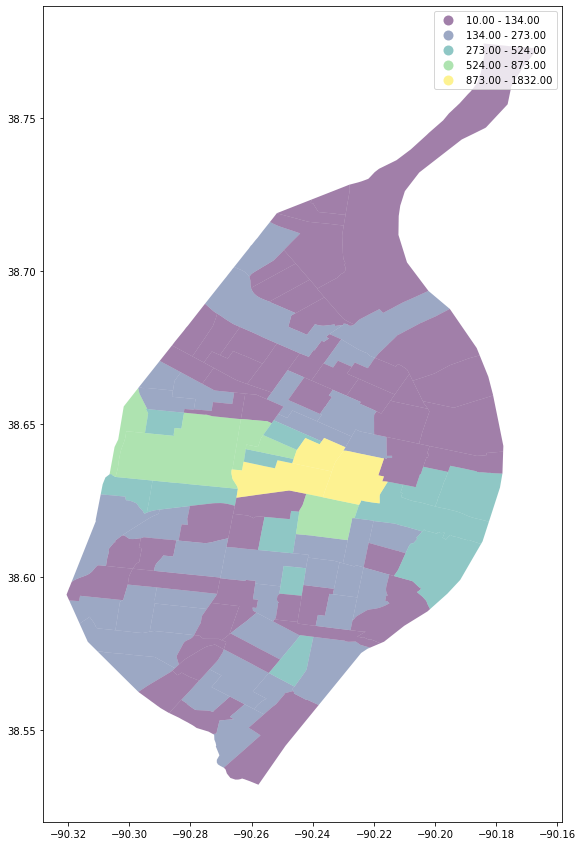

In [86]:
# plot population >= 3 years enrolled in colleges and graduate schools over a map

f, ax = plt.subplots(figsize=(12,15))
describe.plot(column='SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school',
        scheme='FisherJenks', alpha=0.5, ax=ax, legend=True)
ctx.add_basemap(ax, crs=describe.crs.to_string(), source=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()
plt.show()

# save output

# f.savefig("output/school_hostel_base.png")

### **spatial lag**

This is a measure of attribute similarity in paired up neighbors (i.e., geographically similar)

For neighborhood $i$, the spatial lag is defined as: $$ylag_i = \sum_j w_{i,j} y_j$$

The classifier map for the spatial lag tends to enhance the impression of value similarity in space. It is, in effect, a local smoother.

In [87]:
# spatial weights with queen contiguity

wq =  lps.weights.Queen.from_dataframe(describe)
wq.transform = 'r'

In [88]:
# assign weight to y feature

y = describe['SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school']

ylag = lps.weights.lag_spatial(wq, y)

AttributeError: 'dict' object has no attribute 'to_string'

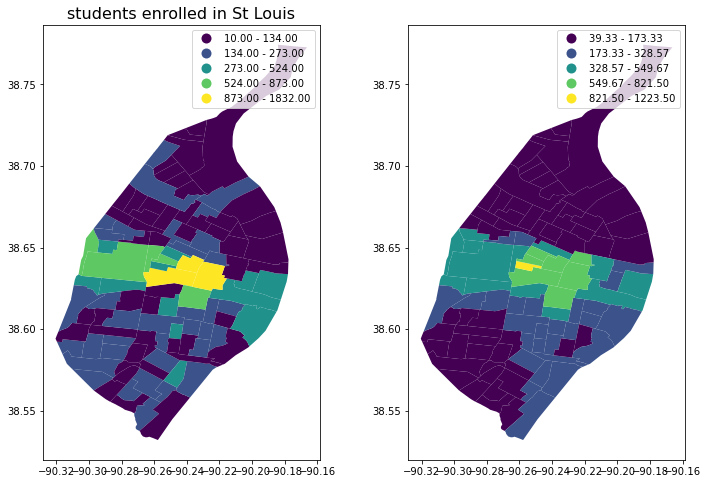

In [89]:
# plot observation before and after over a map

describe['lag_enrolled_students'] = ylag

f,ax = plt.subplots(1,2,figsize=(12,8))

describe.plot(column='SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school',
        ax=ax[0], scheme="FisherJenks",  k=5, legend=True)

ax[0].set_title("students enrolled in St Louis", fontsize=16)

describe.plot(column='lag_enrolled_students', ax=ax[1],
        scheme='FisherJenks', k=5, legend=True)

ctx.add_basemap(ax[0], crs=describe.crs.to_string(), source=ctx.providers.Stamen.TonerLite)

ctx.add_basemap(ax[1], crs=describe.crs.to_string(), source=ctx.providers.Stamen.TonerLite)

ax[1].set_title("Spatial Lag students enrolled in St Louis", fontsize=16)
ax[0].axis('off')
ax[1].axis('off')

plt.show()

# Save the full figure

# f.savefig("output/spatiallag_school_hostel.png")

Feature does not occur randomly across region as shown by the color clusters after spatial lag application

### **spatial autocorrelation**

This relates to the combination of two types of similarity: spatial similarity and attribute similarity.

we plot below using a p-value threshold of 0.05

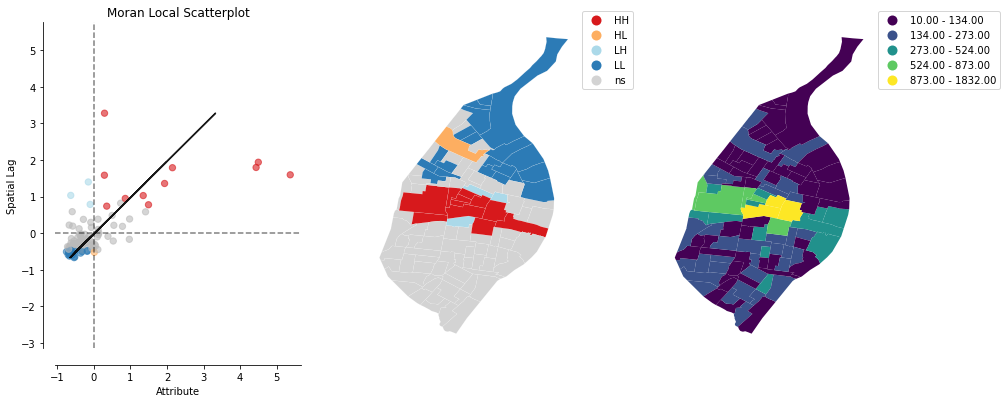

In [90]:
# plot spatial autocorrelation

li = esda.moran.Moran_Local(y, wq)

p_value = 0.05

fig = plot_local_autocorrelation(li, describe,
        'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school',
        p=p_value, scheme='FisherJenks', figsize=(15, 6), cmap="viridis")

plt.show()

Supporting output from spatial lag, we observe high similarities clustered together

<a id="ten"></a>

<center>

## [GEODEMOGRAPHIC SEGMENTATION](https://en.wikipedia.org/wiki/Geodemographic_segmentation)
This includes applying unsupervised learning to demographic and socioeconomic data, followed by a spatial analysis of the results

<a href=#linkme>*back to table of contents*</a>

<center>

In [92]:
cluster = merged_data1.copy()

In [93]:
# create nth clusters from scaled feature values

nth = 6

scaler = StandardScaler()

sl_kmeans = KMeans(n_clusters=nth).fit(scaler.fit_transform(cluster[other_cols]))

In [95]:
# create column for cluster labels

cluster['kmeans'] = sl_kmeans.labels_

cluster.kmeans.unique()

array([0, 5, 1, 4, 2, 3])

In [96]:
cluster.groupby('kmeans')[other_cols].mean()    # observe cluster mean across features

,total,total_male,total_female,total_children_under14,total_youth_15_24,total_adult_25_64,total_seniors_65above,EMPLOYMENT STATUS!!Population 16 years and over,EMPLOYMENT STATUS!!Population 16 years and over!!In labor force,EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force,...,osm_comm_landuse,osm_edu_early,osm_event_center,osm_healthcare,osm_religious_landuse,osm_retail_landuse,osm_sport,osm_sustenance,osm_tourism,osm_transportation
kmeans,,,,,,,,,,,,,,,,,,,,,
0,2538.800000,1281.240000,1257.560000,353.360000,235.840000,1625.360000,324.240000,2162.280000,1603.800000,1589.560000,...,18.080000,1.320000,0.160000,0.840000,5.720000,9.840000,1.760000,7.600000,0.160000,12.240000
1,2033.159091,931.363636,1101.795455,396.068182,251.136364,1088.090909,297.863636,1608.500000,925.613636,924.795455,...,8.090909,1.840909,0.068182,0.250000,9.772727,4.659091,2.727273,1.318182,0.090909,18.045455
2,4647.272727,2214.000000,2433.272727,1040.909091,569.000000,2467.636364,569.727273,3575.636364,2276.545455,2274.454545,...,18.454545,1.545455,0.090909,0.818182,8.272727,13.545455,2.818182,5.272727,0.000000,15.545455
3,5438.000000,3464.000000,1974.000000,348.000000,799.000000,4063.000000,228.000000,5090.000000,4051.000000,3943.000000,...,54.000000,0.000000,2.000000,5.000000,1.000000,30.000000,7.000000,126.000000,2.000000,99.000000
4,3898.142857,2023.285714,1874.857143,290.857143,991.142857,2046.142857,570.000000,3585.571429,2219.857143,2207.571429,...,23.571429,1.285714,0.285714,1.571429,10.571429,14.142857,16.571429,32.285714,1.714286,80.142857
5,4245.937500,2043.750000,2202.187500,605.750000,336.625000,2683.875000,619.687500,3612.250000,2651.000000,2647.000000,...,14.500000,2.187500,0.062500,1.125000,6.437500,7.312500,5.750000,6.500000,0.062500,10.750000


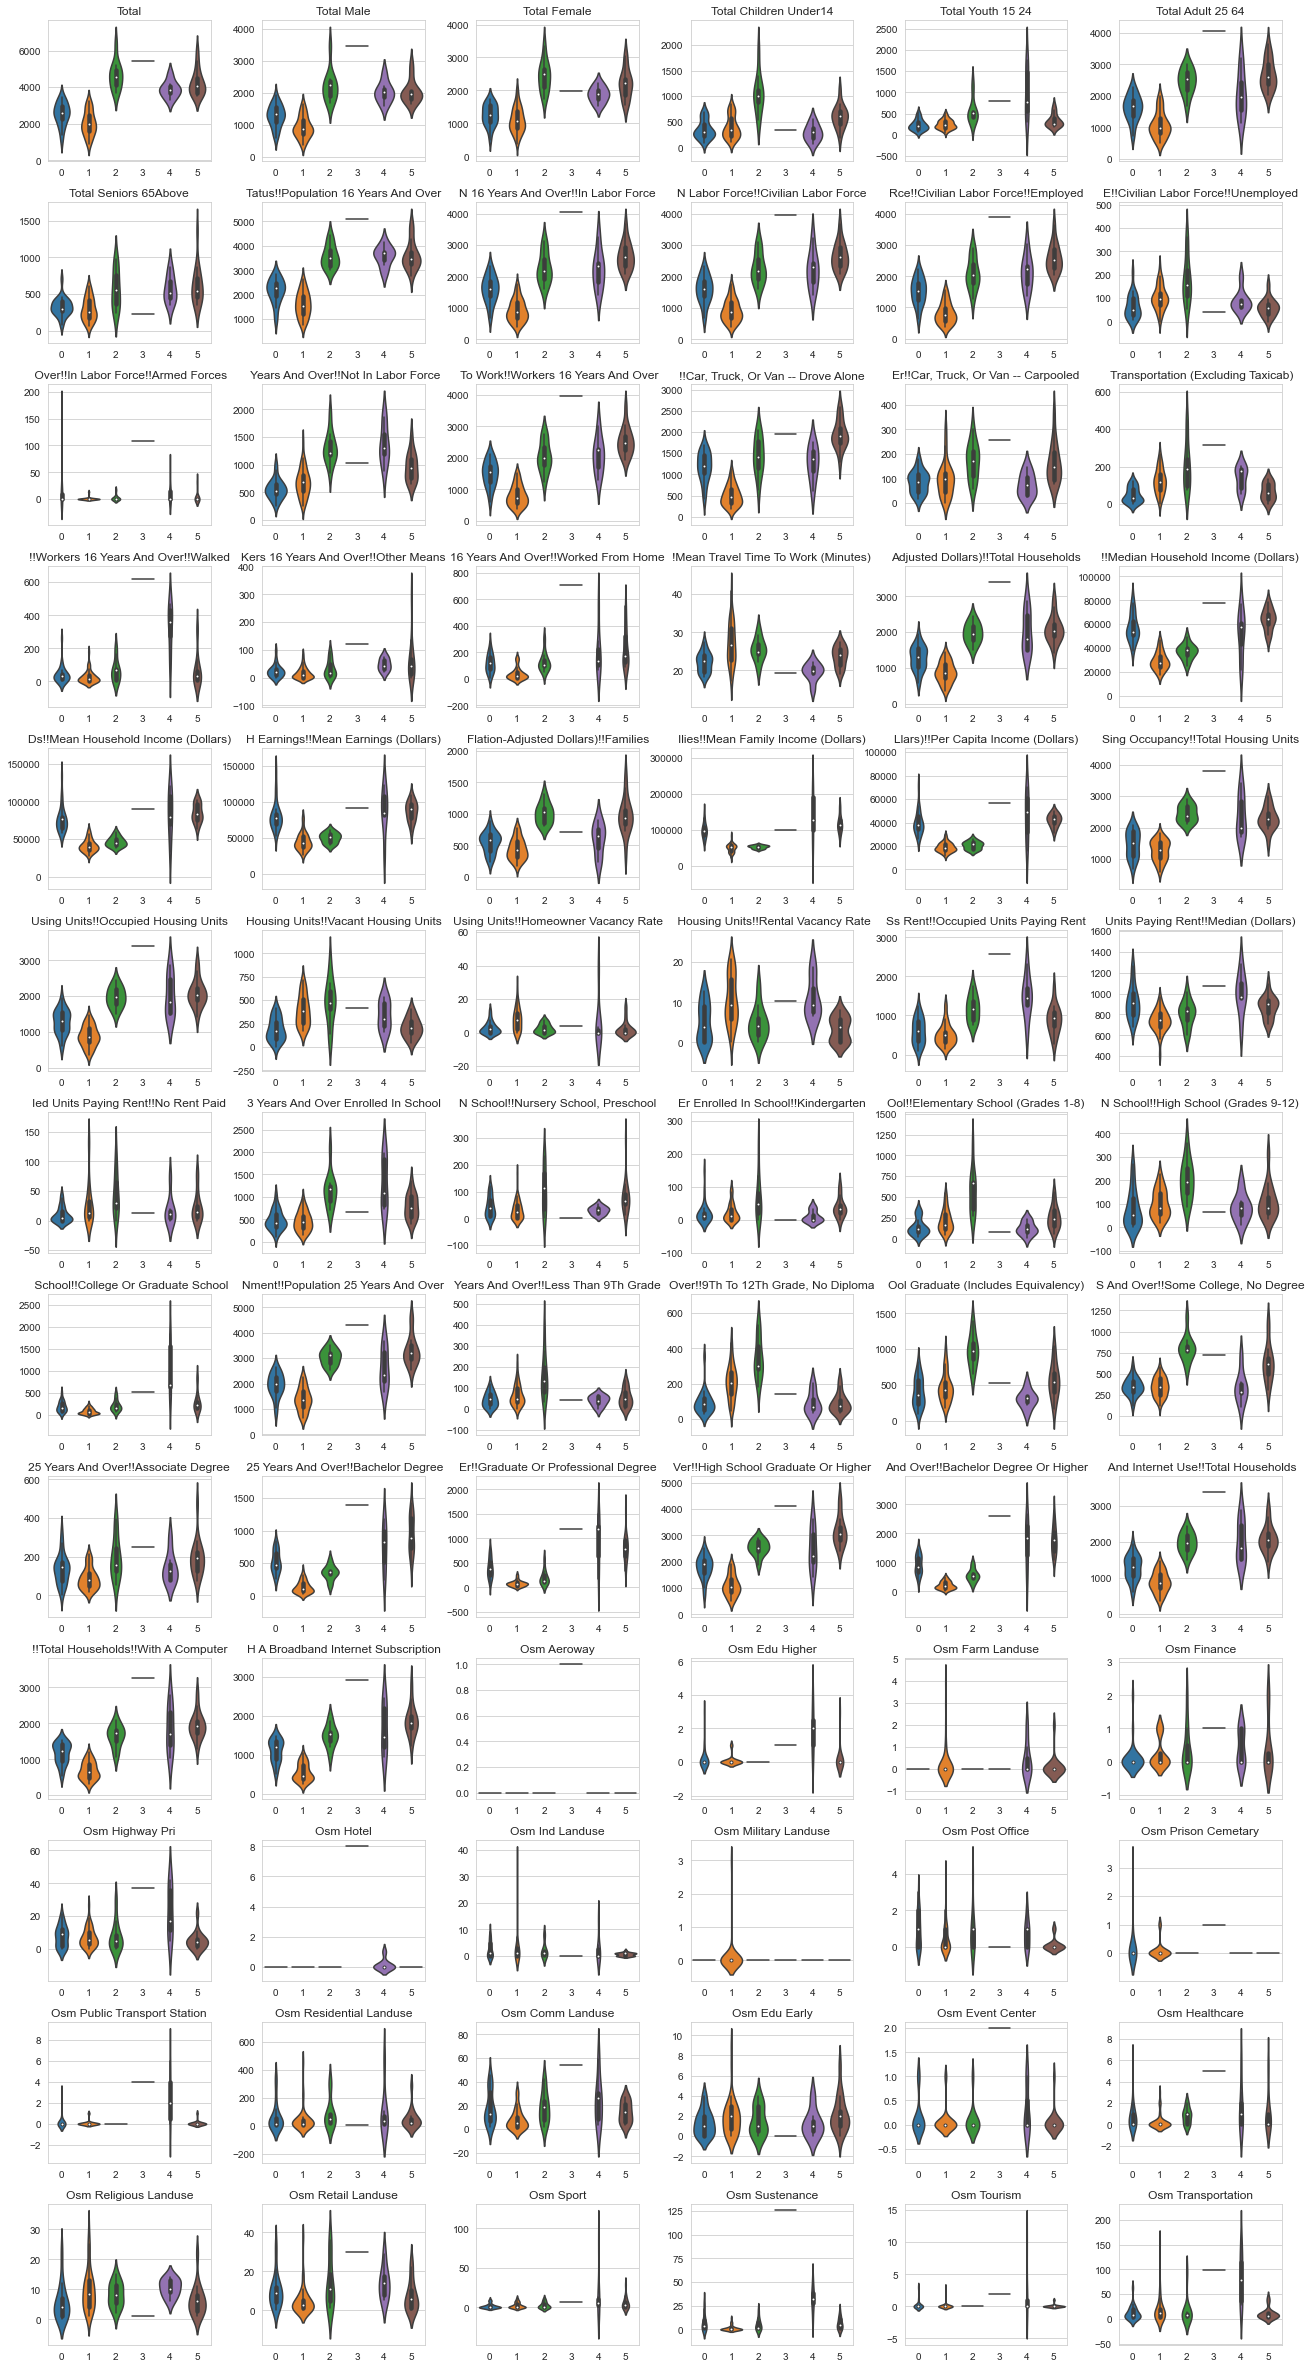

In [97]:
# violin sub plot of all clusters for each feature

sns.set_style('whitegrid')
fig, ax = plt.subplots(13,6, figsize=(18,33))
ax=ax.flatten()
for i, col in enumerate(other_cols):
    sns.violinplot(data=cluster, y=col, x=cluster.kmeans, ax=ax[i])
    ax[i].set_title(col[-35:].replace("_", " ").title())    # reduce title length for clear visual
    ax[i].set(xlabel=None, ylabel=None)
plt.tight_layout()

# save output

# fig.savefig("output/segregation.png")

<a id="eleven"></a>

<center>

## WEIGHTS AND PREDICTION
Assign weights to features based on importance to activity amd make prediction

<a href=#linkme>*back to table of contents*</a>

<center>

In [ ]:
# view all columns except those holding location information

# other_cols

In [99]:
# list of choice columns for student accommodation

student_accom = ['osm_edu_higher',
 'SCHOOL ENROLLMENT!!Population 3 years and over enrolled in school!!College or graduate school',
 'HOUSING OCCUPANCY!!Total housing units!!Rental vacancy rate',
 'osm_healthcare',
 'osm_comm_landuse',
 'osm_highway_pri',
 'osm_prison_cemetary',]

# list of weights for choice columns

student_accom_weight = [6,5,4,3,2,-2,-3]

In [100]:
sl_len = len(student_accom) # length on choice columns

**Min–max normalization** (usually called feature scaling) performs a linear transformation on the original data. This technique gets all the scaled data in the range (0, 1). The formula to achieve this is the following:
$$x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

This preserves the relationships among the original data values. The cost of having this bounded range is that we will end up with smaller standard deviations, which can suppress the effect of outliers and individual range of of features.

In [101]:
# scale features

scaler_mm = MinMaxScaler()

sl_scaled = scaler_mm.fit_transform(merged_dataf[student_accom])

In [102]:
temp = pd.DataFrame(sl_scaled, columns=student_accom)   # convert scaled series to DataFrame

In [103]:
# assign choice weights to features

for i in range(sl_len):
    temp.iloc[:, [i]] = temp.iloc[:, [i]] * student_accom_weight[i]

In [108]:
# sum all to get score for each tract
# base_cols = ['geoid', 'name', 'geometry']
xx = merged_data1[base_cols]
xx.insert(0, "score", temp.sum(axis=1))

In [109]:
# sort DataFrame to get suitability ranking

xx_sort = xx.sort_values(by=["score"], ascending=False)

In [110]:
xx_sort

,score,geoid,name,geometry,centroid
78,12.231266,14000US29510119300,"Census Tract 1193, St. Louis, MO","MULTIPOLYGON (((-90.24663 38.63739, -90.24649 ...",POINT (-3630879.128 -127280.453)
74,11.987102,14000US29510118600,"Census Tract 1186, St. Louis, MO","MULTIPOLYGON (((-90.26661 38.63417, -90.26660 ...",POINT (-3634940.628 -129556.027)
51,11.946352,14000US29510112400,"Census Tract 1124, St. Louis, MO","MULTIPOLYGON (((-90.26626 38.63524, -90.26622 ...",POINT (-3636966.118 -124267.741)
98,9.118625,14000US29510127300,"Census Tract 1273, St. Louis, MO","MULTIPOLYGON (((-90.24539 38.61477, -90.24525 ...",POINT (-3631585.153 -134829.775)
103,8.912919,14000US29510127800,"Census Tract 1278, St. Louis, MO","MULTIPOLYGON (((-90.23665 38.62618, -90.23655 ...",POINT (-3627980.980 -130813.115)
...,...,...,...,...,...
37,-0.352645,14000US29510108300,"Census Tract 1083, St. Louis, MO","MULTIPOLYGON (((-90.24067 38.72259, -90.24067 ...",POINT (-3623966.630 -97934.396)
79,-0.496524,14000US29510120200,"Census Tract 1202, St. Louis, MO","MULTIPOLYGON (((-90.21455 38.65767, -90.21396 ...",POINT (-3621262.312 -121816.023)
6,-0.552728,14000US29510102100,"Census Tract 1021, St. Louis, MO","MULTIPOLYGON (((-90.31027 38.57562, -90.31021 ...",POINT (-3652159.318 -149241.420)
10,-0.589015,14000US29510102500,"Census Tract 1025, St. Louis, MO","MULTIPOLYGON (((-90.28586 38.56940, -90.28572 ...",POINT (-3646359.412 -149599.471)


In [106]:
# Map legend description

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; left: 50px; top: 20px;'>
     
<div class='legend-title'>SITE SUITABILITY</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:green;opacity:0.4;'></span>highly suitable</li>
    <li><span style='background:blue;opacity:0.4;'></span>moderately suitable</li>
    <li><span style='background:orange;opacity:0.4;'></span>marginally suitable</li>
    <li><span style='background:red;opacity:0.4;'></span>not suitable</li>
  </ul>
</div>
<div class='legend-description'>(draggable)</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: center;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-description {
    text-align: center;
    margin-bottom: 2px;
    font-weight: normal;
    font-style: italic;
    font-size: 70%;
    letter-spacing: 1px;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 90%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [111]:
# plot suitability map

# initiate folium map
sl_greymap = folium.Map(location=location, zoom_start=12, tiles='CartoDB positron')

# separate tracts into quartiles
edu_quantile = xx_sort.score.quantile([0.25,0.5,0.75]).tolist()

for q, r in xx_sort.reset_index().iterrows():
        lat_log = [r["centroid"].y, r["centroid"].x]    # tract center
        geoid = r["geoid"]
        name = r["name"]
        score = r['score']

        # custom colors depending on suitability
        if score >= edu_quantile[2]:
            colorize = "green"
        elif score >= edu_quantile[1] and score < edu_quantile[2]:
            colorize = "blue"
        elif score >= edu_quantile[0] and score < edu_quantile[1]:
            colorize = "orange"
        else:
            colorize = "red"

        # simplifying the representation of each tract creates edges close to reality
        sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.00001)

        # create json using specified choice parameters
        d = {'score': [score], 'colorize': [colorize], 'geometry': [sim_geo[0]]}
        geo_j = gpd.GeoDataFrame(d, crs="EPSG:4326").to_json()

        # populate folium map
        geo_j = folium.GeoJson(data=geo_j,
                                style_function=lambda x: {
                                'fillColor': x['properties']['colorize'],
                                'color': 'red',
                                'weight': .5,
                                'dashArray': '5, 5'})

        fig = folium.FeatureGroup(name=q+1)
        geo_j.add_to(fig)
        fig.add_to(sl_greymap)
        
        # specify marker details
        folium.Marker(location=lat_log,
                icon=DivIcon(
                html="""<span class="fa-stack" style="font-size: 10pt; color: blue; text-align:center">
                        <span class="fa fa-circle fa-2x" style="color: white"></span>
                        <strong class="fa-stack-1x">{}</strong>
                        </span>""".format(q+1)),
                popup="""<a href=https://censusreporter.org/profiles/{id}-census-tract-{tract}
                        -st-louis-mo>{name}</a>""".format(id=geoid,
                        tract=name[13:17], name=name), tooltip="Click me!").add_to(sl_greymap)

# add tile options
folium.TileLayer('Open Street Map').add_to(sl_greymap)
folium.TileLayer('Stamen Terrain').add_to(sl_greymap)
folium.TileLayer('Stamen Toner').add_to(sl_greymap)
folium.LayerControl().add_to(sl_greymap)

# add minimap icon
minimap = plugins.MiniMap(position='bottomleft', toggle_display=True, minimized=True)
sl_greymap.add_child(minimap)

# add legend using choice template
macro = MacroElement()
macro._template = Template(template)
sl_greymap.get_root().add_child(macro)

sl_greymap

In [ ]:
# # save folium map
# # mozilla firefox required

# map_name = "output/stlouis_predict.html"
# sl_greymap.save(map_name)

# map_url = "file://{0}/{1}".format(os.getcwd(), map_name)

# driver = webdriver.Firefox()
# driver.get(map_url)
# time.sleep(5)
# driver.save_screenshot("output/stlouis_predict.png")
# driver.quit()

<a id="twelve"></a>

<center>

## STAGE TWO
Small Site / Large Activity

<a href=#linkme>*back to table of contents*</a>

<center>

<a id="twelve_one"></a>
### Large activity
*Sectors within site of interest*

<a href=#twelve>*back to stage two*</a>

**Why Sector and not Industry??**

The terms sector and industry are often used interchangeably to describe a group of companies that operate in the same segment of the economy or share a similar business type. The term sector often refers to a larger, general part of the economy, while the word industry is much more specific and its categorization is more narrow.

Industry will require more customized solution to achieve maximum accuracy

Generalized solutions will work best with sectors <br />

[*investopedia*](https://www.investopedia.com/ask/answers/05/industrysector.asp)

<a id="twelve_two"></a>
### Sectors of interest

<a href=#twelve>*back to stage two*</a>

- Commerce
- Communication
- Education (All, Early and Higher)
- Entertainment
- Food
- Healthcare
- Hospitality
- Industrial
- Logistics / Transportation
- Military
- Religion
- Residential

For any one activity, a major sector will be selected *AND/OR* one or more minor sectors that compliments the major sector

E.g. <br />
Student Accommodation <br />
Major sector    -->     Education (Higher) <br />
Minor Sector    -->     Residential, Healthcare

 <img src="output\flow chart.jpg" />

<a id="twelve_three"></a>
### Making suitability prediction

<a href=#twelve>*back to stage two*</a>

In [ ]:
# read in the different sectors

feature_weight = pd.read_excel("data/Attributes.xlsx", sheet_name="weights_df", index_col=0)

In [ ]:
feature_weight.sample() # random row

In [ ]:
# naming conventions for sector information

sectors = feature_weight.columns.tolist()

sector_weight = [i+"_weight" for i in sectors]

sector_df = [i+"_df" for i in sectors]

In [ ]:
# extract features and corresponding weights for each sector

for i in range(len(sectors)):
    col = sectors[i]
    new_df = feature_weight[[col]][feature_weight[col]!=0]
    vars()[sector_weight[i]] = new_df[col].tolist()
    vars()[col] = new_df.index.tolist()

In [ ]:
# confirm created variables

check = []

for i in range(len(sectors)):
    check.append([vars()[sectors[i]], vars()[sector_weight[i]]])

len(check)

In [ ]:
# input example; in this case for student accommodation

major_sector, major_weight = ["Education_Higher"], 1

minor_sector, minor_weight = ["Residential", "HealthCare"], 0.5

minor_custom_weight = [2, 1]

In [ ]:
# feature scaling and weighting for each sector

for i in range(len(sectors)):
    scaler = MinMaxScaler()
    col = eval(sectors[i])
    scaled = scaler.fit_transform(merged_dataf[col])    # scale feature
    temp = pd.DataFrame(scaled, columns=col)
    for j in range(len(temp.columns)):
        temp.iloc[:, [j]] = temp.iloc[:, [j]] * eval(sector_weight[i])[j]   # assign weight
    xx = merged_dataf[base_cols]
    xx.insert(0, "score", temp.sum(axis=1))     # sum to obtain score per tract
    vars()[sector_df[i]] = xx.copy()

In [ ]:
# function to rank tract suitability

def suitability_ranking(data=merged_dataf, major_sector=major_sector, minor_sector=minor_sector,
    major_weight=major_weight, minor_weight=minor_weight, minor_custom_weight=minor_custom_weight):
    """ 
    Parameters
    ----------
        data: DataFrame
            input data

        major_sector: str or list
            choice major sector (one) for activity  
                
        minor_sector: list
            list of choice minor sector(s) for activity, if any
                
        major_weight: int
            choice weight for major sector
                
        minor_weight: int
            choice weight for all minor sector(s), if any
                
        minor_custom_weight: list
            list of choice weight(s) for each minor sector to be calculated as a fraction of the minor_weight

    Returns
    -------
        DataFrame
    """    
    major_df = eval("".join(major_sector).lower() + "_df").copy()

    # weighting for major and minor sectors
    if minor_sector != []:
        if minor_custom_weight == []:
            n = len(minor_sector)
            weight = [minor_weight/n] * n
        else:
            n = len(minor_custom_weight)
            weight = []
            for i in range(n):
                weight.append((minor_custom_weight[i]/sum(minor_custom_weight))/len(minor_custom_weight))

        minor_df = [i.lower()+"_df" for i in minor_sector]
        for i in range(len(minor_sector)):
            minor_sector_new = eval(minor_df[i]).copy()
            major_df.insert(0, "score_"+ minor_sector[i].lower(), minor_sector_new.loc[:, ["score"]] * weight[i])
        
        major_df["final_score"] = major_df[[i for i in major_df.columns if "score" in i]].sum(axis=1) 
    else:
        major_df["final_score"] = major_df.score

    sorted = major_df.sort_values(by=["final_score"], ascending=False)

    return sorted

In [ ]:
major_df_sort = suitability_ranking()

In [ ]:
major_df_sort

In [ ]:
# function to plot suitability map

def suitability_map(dataframe=major_df_sort):
    """ 
    Parameters
    ----------
        dataframe: DataFrame
            input data

    Returns
    -------
        folium map
    """
    # initiate folium map
    sl_greymap = folium.Map(location=location, zoom_start=12, tiles='CartoDB positron')

    # separate tracts into quartiles
    quantile_calc = dataframe.final_score.quantile([0.25,0.5,0.75]).tolist()

    for q, r in dataframe.reset_index().iterrows():
            lat_log = [r["centroid"].y, r["centroid"].x]    # tract center
            geoid = r["geoid"]
            name = r["name"]
            score = r['score']

            # custom colors depending on suitability
            if score >= quantile_calc[2]:
                colorize = "green"
            elif score >= quantile_calc[1] and score < quantile_calc[2]:
                colorize = "blue"
            elif score >= quantile_calc[0] and score < quantile_calc[1]:
                colorize = "orange"
            else:
                colorize = "red"

            # simplifying the representation of each tract creates edges close to reality
            sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.00001)

            # create json using specified choice parameters
            d = {'score': [score], 'colorize': [colorize], 'geometry': [sim_geo[0]]}
            geo_j = gpd.GeoDataFrame(d, crs="EPSG:4326").to_json()

            # populate folium map
            geo_j = folium.GeoJson(data=geo_j,
                                    style_function=lambda x: {
                                    'fillColor': x['properties']['colorize'],
                                    'color': 'red',
                                    'weight': .5,
                                    'dashArray': '5, 5'})

            fig = folium.FeatureGroup(name=q+1)
            geo_j.add_to(fig)
            fig.add_to(sl_greymap)
            
            # specify marker details
            folium.Marker(location=lat_log,
                    icon=DivIcon(
                    html="""<span class="fa-stack" style="font-size: 10pt; color: blue; text-align:center">
                            <span class="fa fa-circle fa-2x" style="color: white"></span>
                            <strong class="fa-stack-1x">{}</strong>
                            </span>""".format(q+1)),
                    popup="""<a href=https://censusreporter.org/profiles/{id}-census-tract-{tract}
                            -st-louis-mo>{name}</a>""".format(id=geoid,
                            tract=name[13:17], name=name), tooltip="Click me!").add_to(sl_greymap)

    # add tile options
    folium.TileLayer('Open Street Map').add_to(sl_greymap)
    folium.TileLayer('Stamen Terrain').add_to(sl_greymap)
    folium.TileLayer('Stamen Toner').add_to(sl_greymap)
    folium.LayerControl().add_to(sl_greymap)

    # add minimap icon
    minimap = plugins.MiniMap(position='bottomleft', toggle_display=True, minimized=True)
    sl_greymap.add_child(minimap)

    # add legend using choice template
    macro = MacroElement()
    macro._template = Template(template)
    sl_greymap.get_root().add_child(macro)

    return sl_greymap

In [ ]:
suitability_map()

In [ ]:
# # save folium map
# # mozilla firefox required

# map_name = "output/stlouis_predict2.html"
# suitability_map().save(map_name)

# map_url = "file://{0}/{1}".format(os.getcwd(), map_name)

# driver = webdriver.Firefox()
# driver.get(map_url)
# time.sleep(5)
# driver.save_screenshot("output/stlouis_predict2.png")
# driver.quit()

In [120]:
# from IPython.display import HTML
# # HTML(filename='output/stlouis_predict2.html')

# from IPython.core.display import display, HTML
# # display(HTML(filename='output/stlouis_predict2.html'))